In [1]:
import h5py
import numpy as np
import pandas as pd
import scipy
from scipy import signal
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import metrics
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

2023-04-16 13:42:31.081487: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def getData(cfileName):

    # Read the *.cfile which has each element in float32 format.
    data = np.fromfile(cfileName, dtype="float32")

    # Take each consecutive interleaved I sample and Q sample to create a single complex element.
    data = data[0::2] + 1j*data[1::2]
    #print("data type=", type(data))
    # Return the complex numpy array.
    return data

def create_dataset(data, class_label):
    f, t, Zxx = signal.stft(data, fs=20e6, nperseg=fft_size, noverlap=fft_overlap)
    print(len(f))
    print(len(t))
    print(Zxx.shape)

    del data

    Zxx = Zxx.transpose()

    Zxx = abs(Zxx)
    # scaling the features (only real part of the data can be used)
    scaler = MinMaxScaler()
    scaler.fit(Zxx)
    print(scaler.data_max_)
    Zxx = scaler.transform(Zxx)

    X = Zxx[:num_samp_per_class]
    Y = np.full(num_samp_per_class, class_label)

    return X, Y

# number of samples per class
num_samp_per_class = 10000

# FFT size for the STFT operation (which is same as the feature vector size)
fft_size = feature_vector_size = 2048 #1024

# number of overlapping samples for the STFT operation
fft_overlap = 256

## Nordic Device-30(iv) dataset

In [3]:
class_label = 8
for i in range(class_label):

    folder_path = "/Volumes/Transcend/PhD in Computing/Data Collection/Nordic/32MHz/Device-30(iv)/"

    if(i==0):
        data = getData(folder_path + "BLINK_new.cfile")
        print(np.array(data))
        X, Y = create_dataset(data, i)

    else:

        if(i==1):
            data = getData(folder_path + "blinky_freertos.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==2):
            data = getData(folder_path + "blinky_rtc_freertos.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==3):
            data = getData(folder_path + "blinky_systick.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==4):
            data = getData(folder_path + "blinky.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==5):
            data = getData(folder_path + "IDLE_new.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==6):
            data = getData(folder_path + "led_softblink.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==7):
            data = getData(folder_path + "Matrix_MUL_new.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        X = np.concatenate((X, dataset), axis=0) 
        Y = np.concatenate((Y, label), axis=0)
        
    print(i)
    print(X.shape)
    print(Y.shape)

# combine all em signals into one dataframe
em_data = pd.DataFrame(X)
em_data.insert(len(em_data.columns), 'labels', Y)

# save to csv file
#(em_data.T).to_csv(f'/Users/Lojenaa/Documents/DELL_Linux/Lojenaa/HackRF One/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone6S/i6S_I.csv', header=False)
# (em_data.T).to_csv(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone8/i8_I.csv', header=False)

[ 0.0234375-0.0546875j  0.015625 +0.0390625j -0.0078125+0.09375j   ...
  0.       +0.0390625j  0.0703125-0.1015625j  0.0390625-0.0078125j]
2048
79729
(2048, 79729)
[0.02592004 0.01550449 0.0057586  ... 0.00465551 0.0053518  0.01526976]
0
(10000, 2048)
(10000,)
[-0.0078125-0.03125j   -0.0703125+0.046875j   0.0859375-0.0546875j ...
 -0.015625 +0.j        -0.078125 -0.03125j   -0.015625 -0.0234375j]
2048
92308
(2048, 92308)
[0.0259731  0.01490589 0.0055895  ... 0.00483991 0.0046817  0.01494553]
1
(20000, 2048)
(20000,)
[ 0.0078125-0.1328125j  0.       -0.0234375j -0.03125  -0.0625j    ...
  0.0625   -0.0390625j  0.0234375+0.j         0.0703125-0.0078125j]
2048
83313
(2048, 83313)
[0.02563546 0.01518829 0.00539794 ... 0.00510627 0.00546732 0.01556452]
2
(30000, 2048)
(30000,)
[ 0.0234375+0.0703125j -0.0234375+0.0390625j  0.09375  +0.078125j  ...
  0.046875 -0.0234375j  0.015625 +0.109375j   0.0546875+0.j       ]
2048
79583
(2048, 79583)
[0.02566977 0.01504102 0.00494757 ... 0.00447381 0.00

## Cross-model Validation applying the Model of other set of samples

Nordic Device-25(i) model to Nordic Device-30(iv) dataset 

In [4]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(i)_model.h5")

2023-04-16 13:57:36.066174: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 14s 5ms/step - loss: 4.4310 - accuracy: 0.1381
test loss, test acc: [4.431024551391602, 0.13808749616146088]


In [6]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 11s 4ms/step
[5 2 5 ... 5 5 5]
5
[[   0    0 4603   13   32 5212  134    6]
 [   0   24 7069    1    0 2819   14   73]
 [   0    1 5690    7   18 4139  103   42]
 [   0    0 4956    1    5 4965   38   35]
 [  21 9566   29  103   87    1   29  164]
 [   0    0 5030    4   22 4841   94    9]
 [   0    0 5248    0    3 4316  267  166]
 [   0    0 5927    4    4 3763  165  137]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10000
           1       0.00      0.00      0.00     10000
           2       0.15      0.57      0.23     10000
           3       0.01      0.00      0.00     10000
           4       0.51      0.01      0.02     10000
           5       0.16      0.48      0.24     10000
           6       0.32      0.03      0.05     10000
           7       0.22      0.01      0.03     10000

    accuracy                           0.14     80000
   macro avg       0.17      0.14  

Test Accuracy:0.1380875


Text(0.5, 1.0, 'Accuracy:0.138')

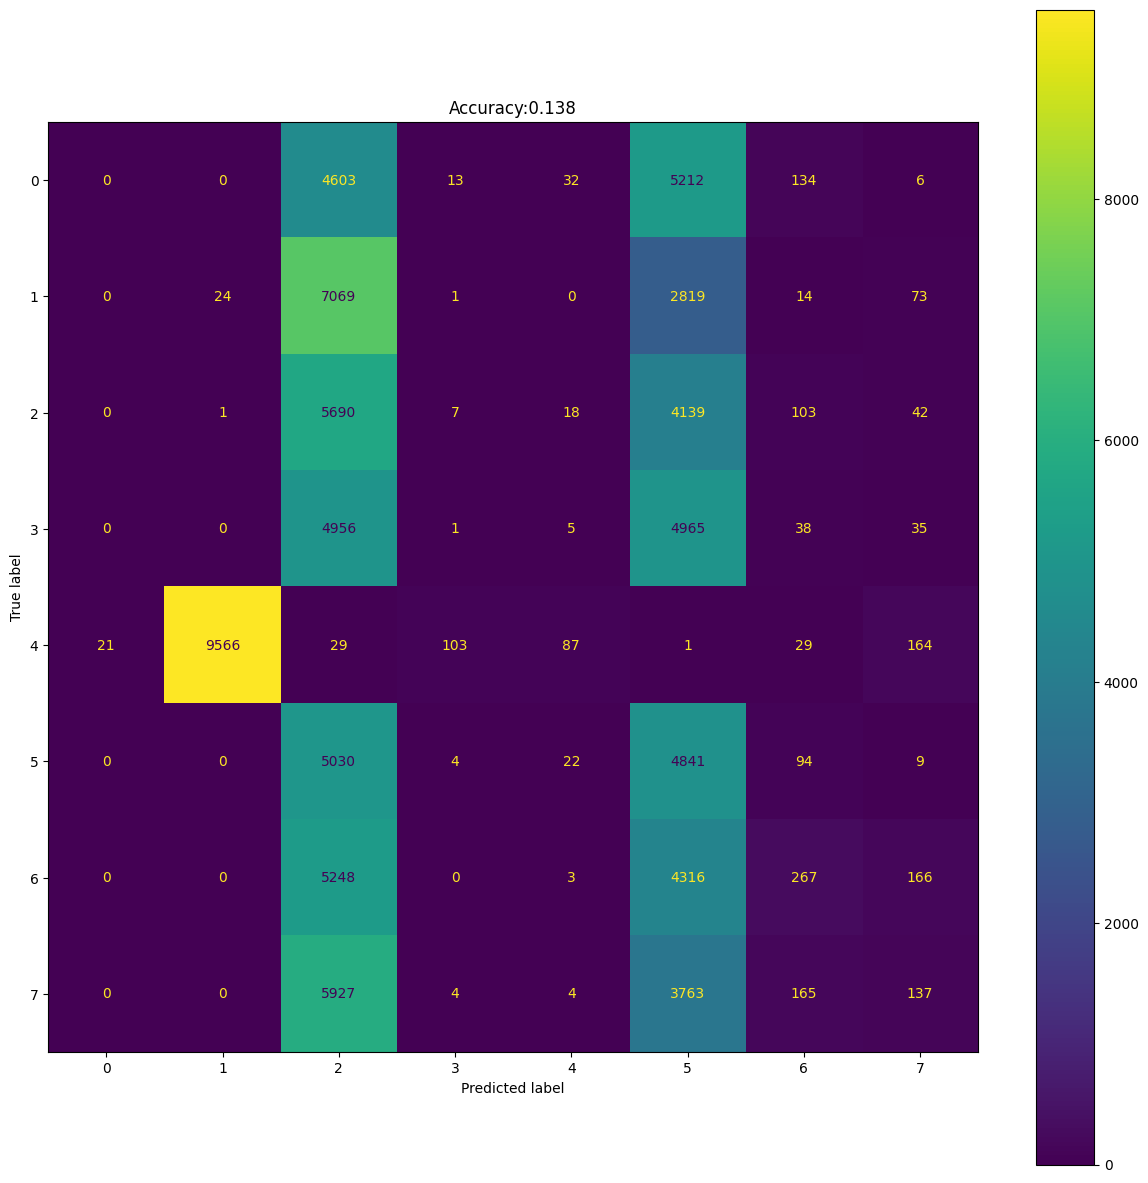

In [7]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

Nordic Device-25(i) model to Nordic Device-30(iv) dataset 

In [8]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(i)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [9]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [10]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 2.3386 - accuracy: 0.2095
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.8772 - accuracy: 0.2442
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.6882 - accuracy: 0.3848
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.5890 - accuracy: 0.4218
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.5248 - accuracy: 0.4398
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.4806 - accuracy: 0.4538
Epoch 7/30
2500/2500 [==============================] - 14s 5ms/step - loss: 1.4479 - accuracy: 0.4648
Epoch 8/30
2500/2500 [==============================] - 13s 5ms/step - loss: 1.4224 - accuracy: 0.4735
Epoch 9/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.4023 - accuracy: 0.4812
Epoch 10/30
2500/2500 [==============================] - 12s 5ms/step - l

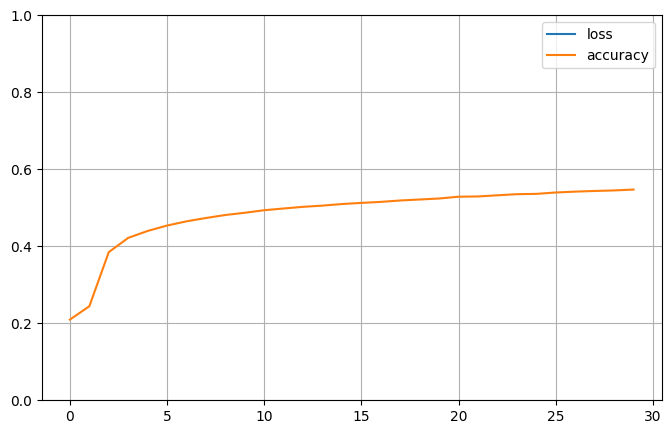

In [11]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [12]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 1.2394 - accuracy: 0.5498
test loss, test acc: [1.2394402027130127, 0.5498499870300293]


In [13]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 11s 5ms/step
[0 2 5 ... 2 7 7]
0
[[2785  497 1762  867    0 2542  608  939]
 [ 209 6982  798  634   13  296  699  369]
 [ 948  983 3612 1107    1 1641  725  983]
 [ 583  900 1237 4556    1 1033  936  754]
 [  90    0    3    0 9859    0   38   10]
 [1381  467 1851 1185    0 3467  697  952]
 [ 173  562  472  610    1  322 7283  577]
 [ 564  320 1083  814    2  876  897 5444]]
              precision    recall  f1-score   support

           0       0.41      0.28      0.33     10000
           1       0.65      0.70      0.67     10000
           2       0.33      0.36      0.35     10000
           3       0.47      0.46      0.46     10000
           4       1.00      0.99      0.99     10000
           5       0.34      0.35      0.34     10000
           6       0.61      0.73      0.67     10000
           7       0.54      0.54      0.54     10000

    accuracy                           0.55     80000
   macro avg       0.55      0.55  

Test Accuracy:0.54985


Text(0.5, 1.0, 'Accuracy:0.550')

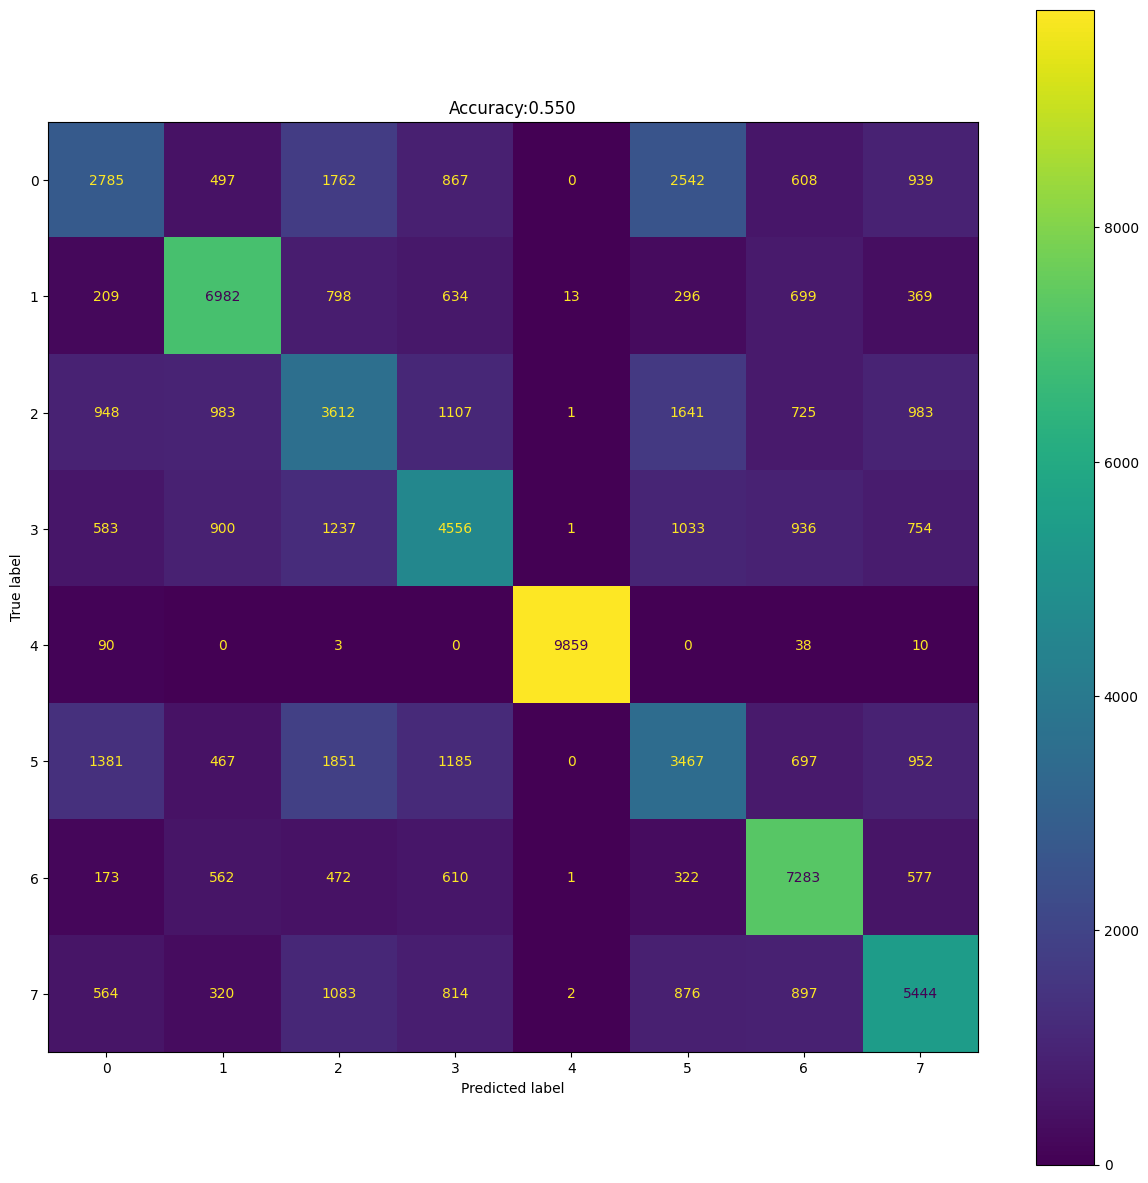

In [14]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation applying the Model of other Device samples

Nordic Device-25(ii) model to Nordic Device-30(iv) dataset 

In [15]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(ii)_model.h5")

In [16]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 13s 5ms/step - loss: 5.7408 - accuracy: 0.1232
test loss, test acc: [5.7407546043396, 0.1231750026345253]


In [17]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 12s 5ms/step
[2 5 5 ... 5 6 2]
2
[[  23    1 3639    0    0 5993  342    2]
 [   0    0 4253    0    1 4670 1051   25]
 [  20    0 3362    0    1 6183  423   11]
 [ 206  135 1392    0    0 6565 1651   51]
 [  15 7849   71   34    3    0 1794  234]
 [  28    3 3403    0    3 6011  547    5]
 [ 256    7 2920    0    3 6143  395  276]
 [  83   11 4027    0    0 5203  616   60]]
              precision    recall  f1-score   support

           0       0.04      0.00      0.00     10000
           1       0.00      0.00      0.00     10000
           2       0.15      0.34      0.20     10000
           3       0.00      0.00      0.00     10000
           4       0.27      0.00      0.00     10000
           5       0.15      0.60      0.24     10000
           6       0.06      0.04      0.05     10000
           7       0.09      0.01      0.01     10000

    accuracy                           0.12     80000
   macro avg       0.09      0.12  

Test Accuracy:0.123175


Text(0.5, 1.0, 'Accuracy:0.123')

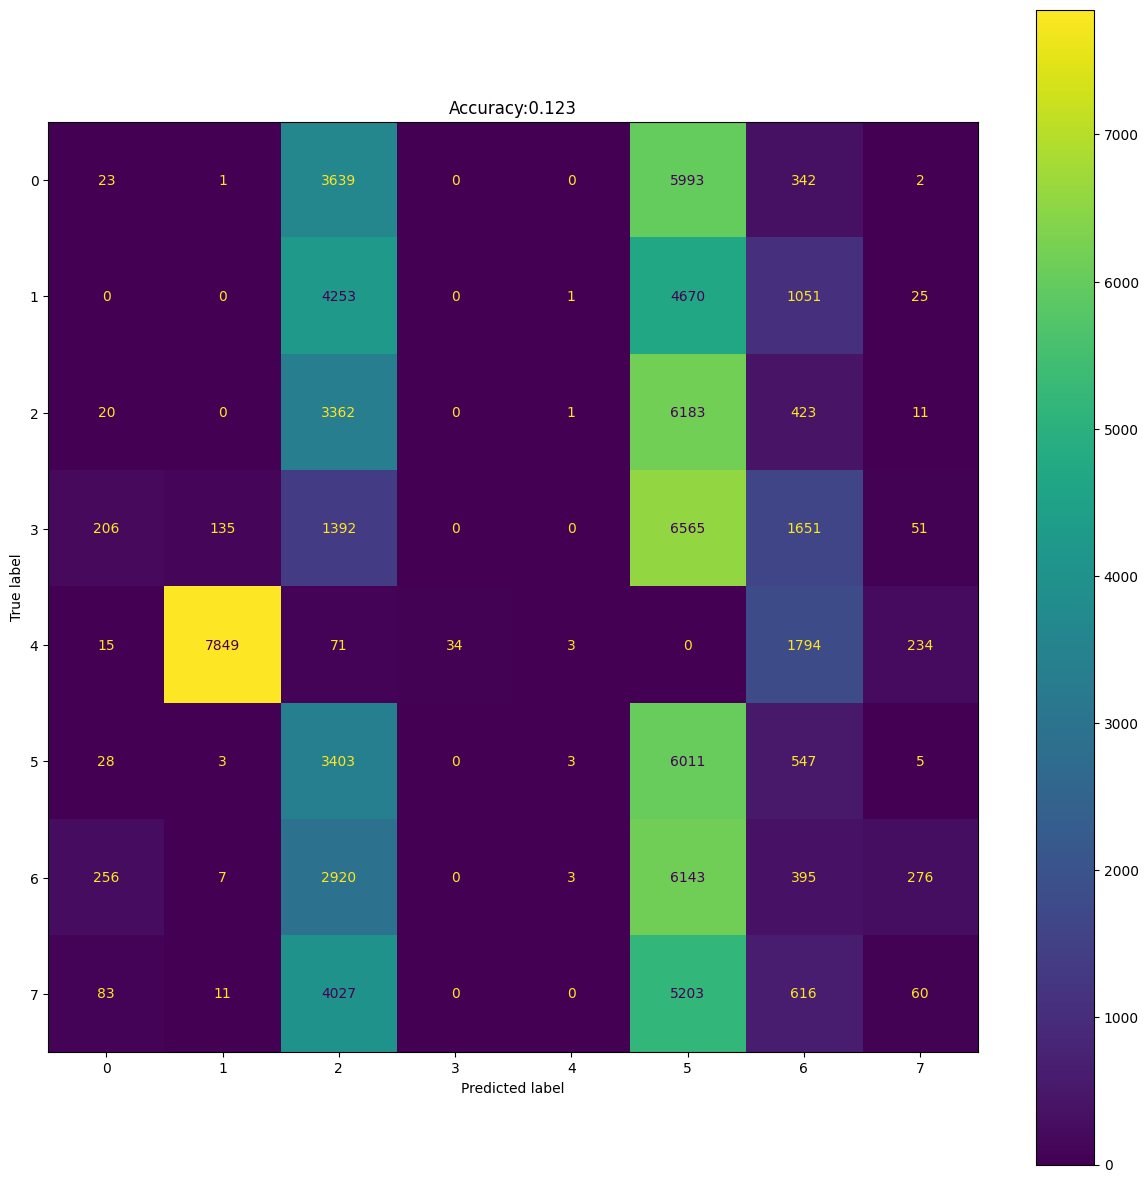

In [18]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [19]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(ii)_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [20]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [21]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 12s 5ms/step - loss: 2.7760 - accuracy: 0.1325
Epoch 2/30
2500/2500 [==============================] - 11s 5ms/step - loss: 1.8556 - accuracy: 0.2607
Epoch 3/30
2500/2500 [==============================] - 12s 5ms/step - loss: 1.6524 - accuracy: 0.4241
Epoch 4/30
2500/2500 [==============================] - 13s 5ms/step - loss: 1.5505 - accuracy: 0.4484
Epoch 5/30
2500/2500 [==============================] - 14s 5ms/step - loss: 1.4888 - accuracy: 0.4641
Epoch 6/30
2500/2500 [==============================] - 13s 5ms/step - loss: 1.4477 - accuracy: 0.4751
Epoch 7/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.4186 - accuracy: 0.4833
Epoch 8/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.3961 - accuracy: 0.4905
Epoch 9/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.3785 - accuracy: 0.4965
Epoch 10/30
2500/2500 [==============================] - 11s 4ms/step - l

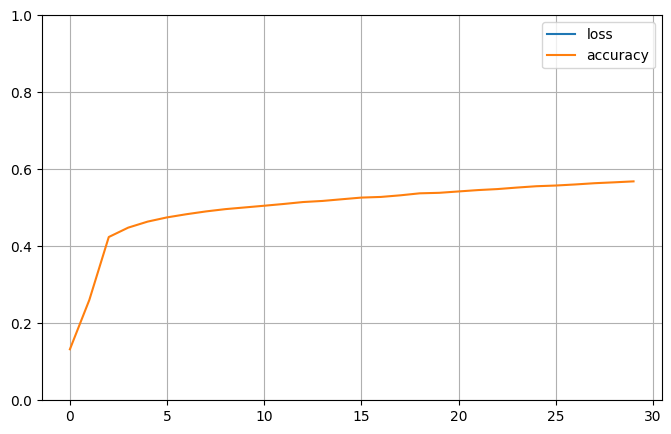

In [22]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [23]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 1.2064 - accuracy: 0.5708
test loss, test acc: [1.206397533416748, 0.5708000063896179]


In [24]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 12s 5ms/step
[5 3 0 ... 6 3 7]
5
[[2911 1017 1191 1162    1 2390  496  832]
 [ 273 8071  262  340    9  298  243  504]
 [1277 1224 2494 1243    1 1987  673 1101]
 [ 222  331  444 6992    9  853  713  436]
 [   0   37    0    5 9895    7   56    0]
 [1249  790 1043 1529    0 3946  664  779]
 [ 151  580  566 1184    2  665 6332  520]
 [ 521 1052  506 1149    1 1061  687 5023]]
              precision    recall  f1-score   support

           0       0.44      0.29      0.35     10000
           1       0.62      0.81      0.70     10000
           2       0.38      0.25      0.30     10000
           3       0.51      0.70      0.59     10000
           4       1.00      0.99      0.99     10000
           5       0.35      0.39      0.37     10000
           6       0.64      0.63      0.64     10000
           7       0.55      0.50      0.52     10000

    accuracy                           0.57     80000
   macro avg       0.56      0.57  

Test Accuracy:0.5708


Text(0.5, 1.0, 'Accuracy:0.571')

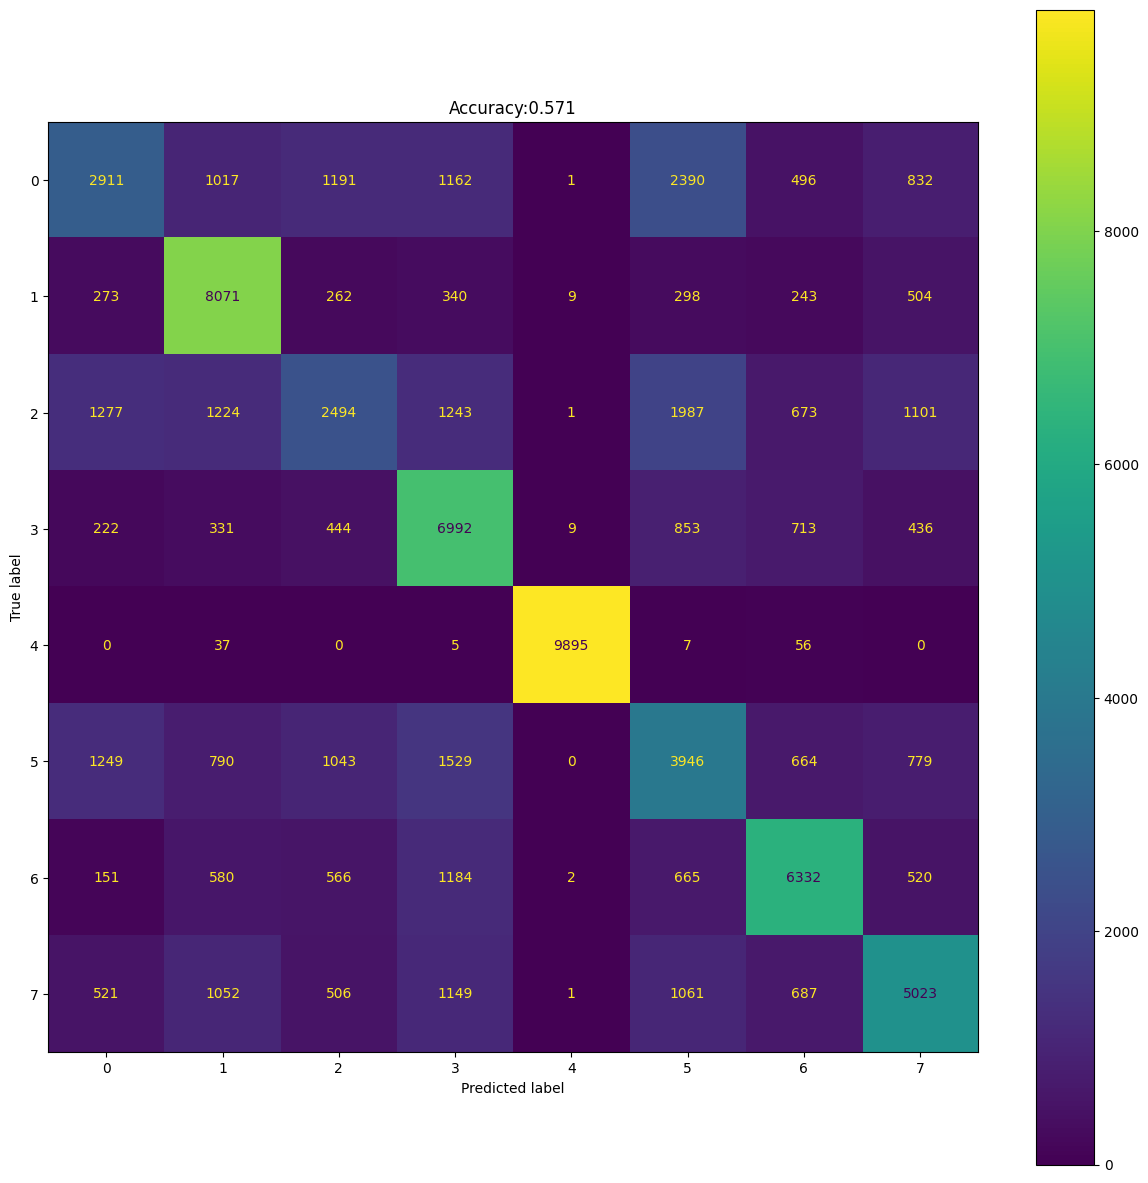

In [25]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-25(iii) model to Nordic Device-30(iv) dataset 

In [26]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(iii)_model.h5")

In [27]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 13s 5ms/step - loss: 4.6054 - accuracy: 0.1381
test loss, test acc: [4.605442047119141, 0.1381250023841858]


In [28]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 11s 4ms/step
[5 4 5 ... 5 0 3]
5
[[ 516   53 1073  176  644 6992  474   72]
 [ 258  326  429 1194  260 4967 2424  142]
 [ 526   25  628  148  861 7362  406   44]
 [3303   27  929  131  134 5108  352   16]
 [   2 9536  176   57   18   62  104   45]
 [ 407   95 1042  325  308 6823  894  106]
 [ 546  124 1379   98   43 5169 2605   36]
 [1694   19  363  429  821 5805  866    3]]
              precision    recall  f1-score   support

           0       0.07      0.05      0.06     10000
           1       0.03      0.03      0.03     10000
           2       0.10      0.06      0.08     10000
           3       0.05      0.01      0.02     10000
           4       0.01      0.00      0.00     10000
           5       0.16      0.68      0.26     10000
           6       0.32      0.26      0.29     10000
           7       0.01      0.00      0.00     10000

    accuracy                           0.14     80000
   macro avg       0.09      0.14  

Test Accuracy:0.138125


Text(0.5, 1.0, 'Accuracy:0.138')

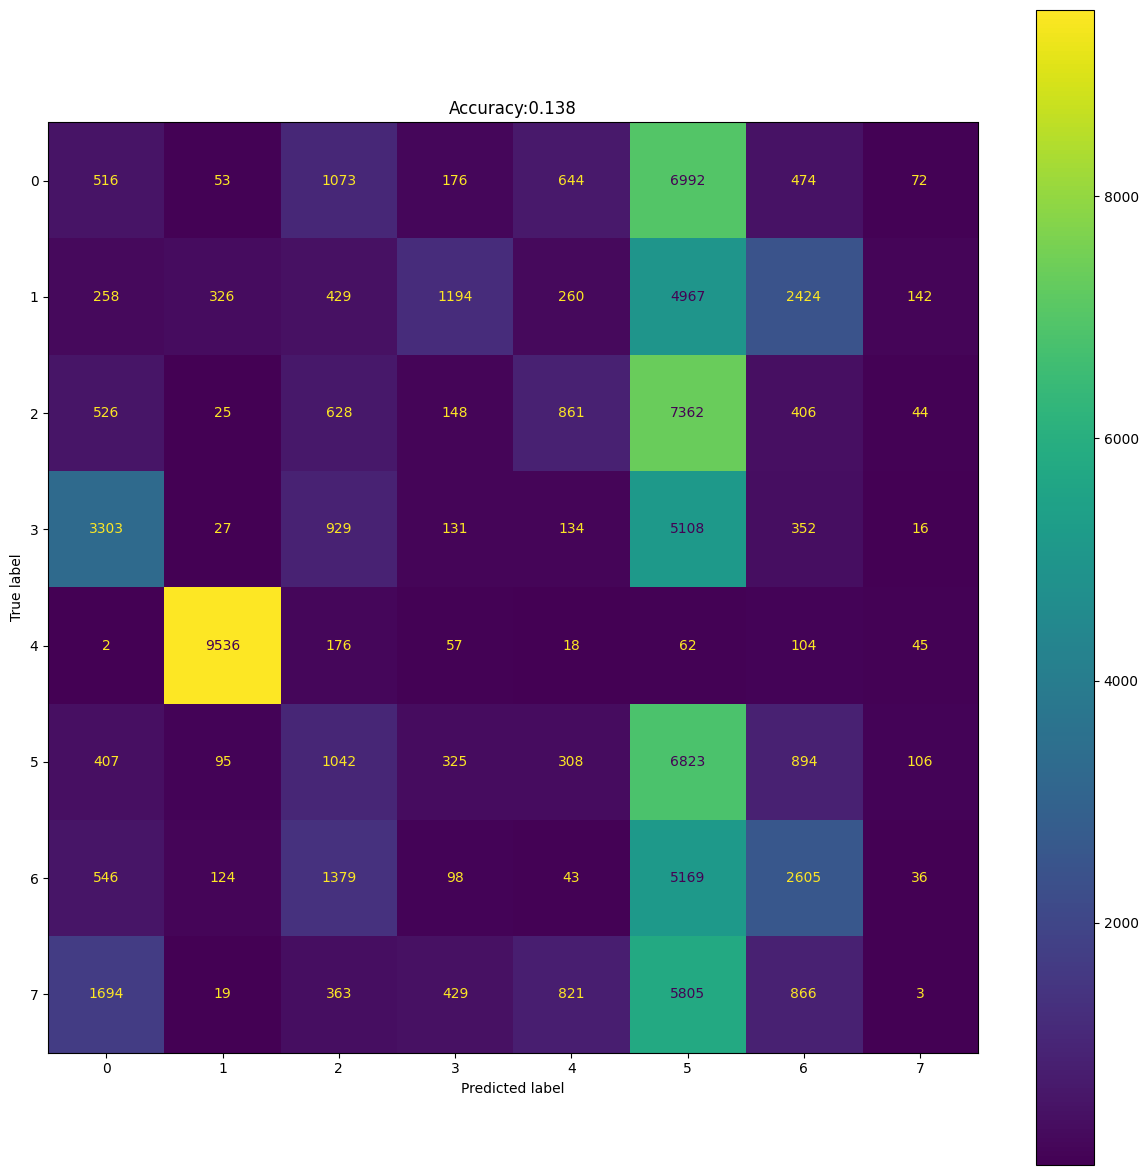

In [29]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning

Nordic Device-25(iii) model to Nordic Device-30(iv) dataset 

In [30]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(iii)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [31]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [32]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 12s 5ms/step - loss: 2.8812 - accuracy: 0.1579
Epoch 2/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.9537 - accuracy: 0.2537
Epoch 3/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.6944 - accuracy: 0.3434
Epoch 4/30
2500/2500 [==============================] - 11s 5ms/step - loss: 1.5741 - accuracy: 0.4537
Epoch 5/30
2500/2500 [==============================] - 12s 5ms/step - loss: 1.5006 - accuracy: 0.4685
Epoch 6/30
2500/2500 [==============================] - 11s 5ms/step - loss: 1.4509 - accuracy: 0.4790
Epoch 7/30
2500/2500 [==============================] - 12s 5ms/step - loss: 1.4151 - accuracy: 0.4883
Epoch 8/30
2500/2500 [==============================] - 12s 5ms/step - loss: 1.3883 - accuracy: 0.4951
Epoch 9/30
2500/2500 [==============================] - 13s 5ms/step - loss: 1.3670 - accuracy: 0.5001
Epoch 10/30
2500/2500 [==============================] - 13s 5ms/step - l

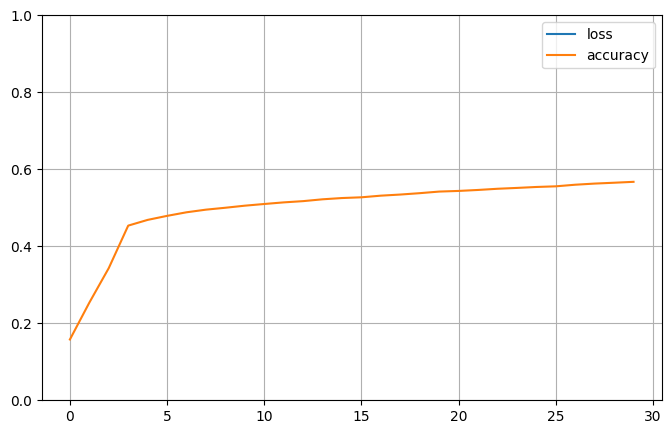

In [33]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [34]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 1.1970 - accuracy: 0.5692
test loss, test acc: [1.1970489025115967, 0.5692124962806702]


In [35]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 11s 5ms/step
[2 0 0 ... 5 3 7]
2
[[2558  489 2176  997    6 1847  826 1101]
 [ 118 6737  441  528   20  560  843  753]
 [1285  556 3522  948    1 1488  652 1548]
 [ 301  330  391 6862    2  591  632  891]
 [  29    3   32   11 9922    2    1    0]
 [ 869 1143 1144 1070    5 3524 1068 1177]
 [ 208  886  514  857   24  617 6379  515]
 [ 376  591 1141  808    0  626  425 6033]]
              precision    recall  f1-score   support

           0       0.45      0.26      0.32     10000
           1       0.63      0.67      0.65     10000
           2       0.38      0.35      0.36     10000
           3       0.57      0.69      0.62     10000
           4       0.99      0.99      0.99     10000
           5       0.38      0.35      0.37     10000
           6       0.59      0.64      0.61     10000
           7       0.50      0.60      0.55     10000

    accuracy                           0.57     80000
   macro avg       0.56      0.57  

Test Accuracy:0.5692125


Text(0.5, 1.0, 'Accuracy:0.569')

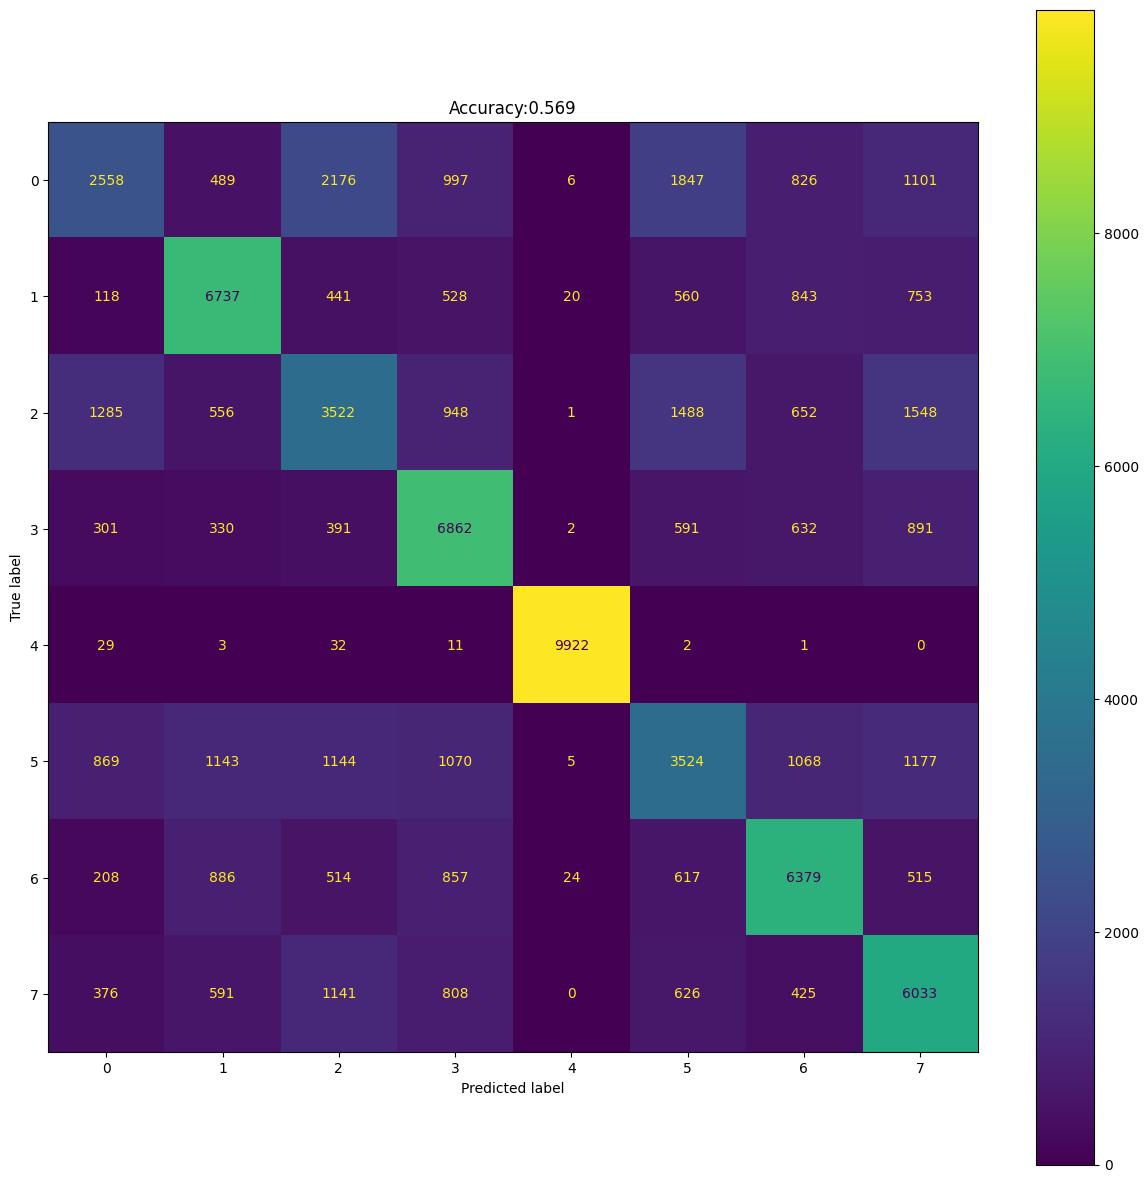

In [36]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-25(iv) model to Nordic Device-30(iv) dataset 

In [37]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(iv)_model.h5")

In [38]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 13s 5ms/step - loss: 4.4681 - accuracy: 0.1289
test loss, test acc: [4.468085765838623, 0.12894999980926514]


In [39]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 12s 5ms/step
[2 1 2 ... 6 0 5]
2
[[ 940   23 1663  113  630 5617  685  329]
 [1686   19  902  174  910 4497 1356  456]
 [ 802    9  809   92  769 6030 1071  418]
 [3250    4  172   35 3018 2939  483   99]
 [9499   23   50   75   16   94  237    6]
 [1193   11  684  137 1070 5919  760  226]
 [1923    4  116   20 1320 3987 2556   74]
 [2033   23  397  150  647 5925  803   22]]
              precision    recall  f1-score   support

           0       0.04      0.09      0.06     10000
           1       0.16      0.00      0.00     10000
           2       0.17      0.08      0.11     10000
           3       0.04      0.00      0.01     10000
           4       0.00      0.00      0.00     10000
           5       0.17      0.59      0.26     10000
           6       0.32      0.26      0.28     10000
           7       0.01      0.00      0.00     10000

    accuracy                           0.13     80000
   macro avg       0.12      0.13  

Test Accuracy:0.12895


Text(0.5, 1.0, 'Accuracy:0.129')

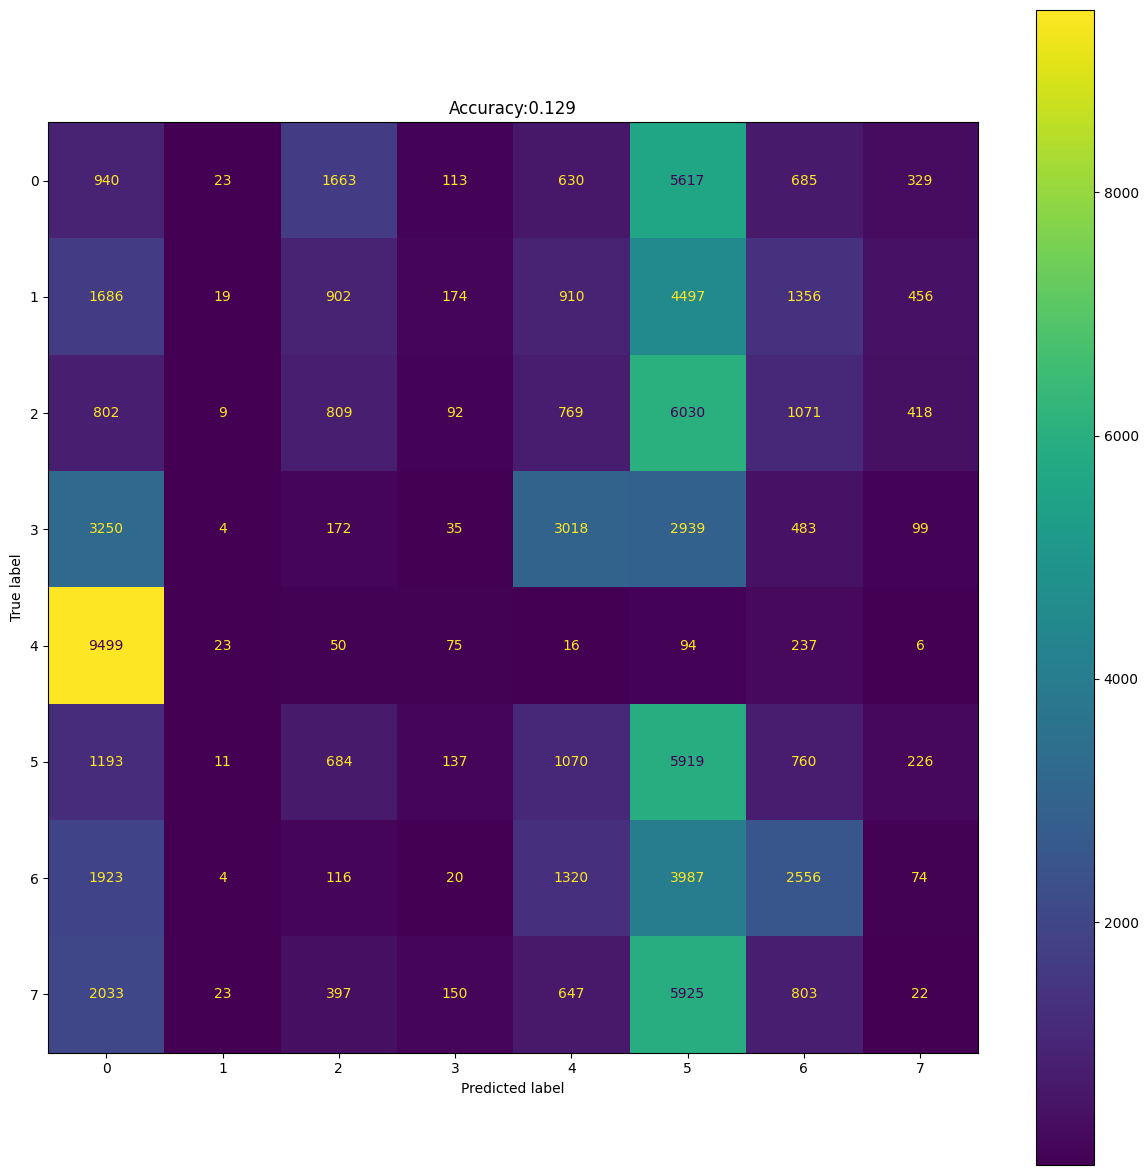

In [40]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [41]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(iv)_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [42]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [43]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 12s 5ms/step - loss: 2.8146 - accuracy: 0.1582
Epoch 2/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.9889 - accuracy: 0.2529
Epoch 3/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.7231 - accuracy: 0.4140
Epoch 4/30
2500/2500 [==============================] - 12s 5ms/step - loss: 1.6117 - accuracy: 0.4520
Epoch 5/30
2500/2500 [==============================] - 13s 5ms/step - loss: 1.5482 - accuracy: 0.4701
Epoch 6/30
2500/2500 [==============================] - 12s 5ms/step - loss: 1.5051 - accuracy: 0.4786
Epoch 7/30
2500/2500 [==============================] - 13s 5ms/step - loss: 1.4727 - accuracy: 0.4861
Epoch 8/30
2500/2500 [==============================] - 14s 6ms/step - loss: 1.4474 - accuracy: 0.4924
Epoch 9/30
2500/2500 [==============================] - 13s 5ms/step - loss: 1.4264 - accuracy: 0.4973
Epoch 10/30
2500/2500 [==============================] - 13s 5ms/step - l

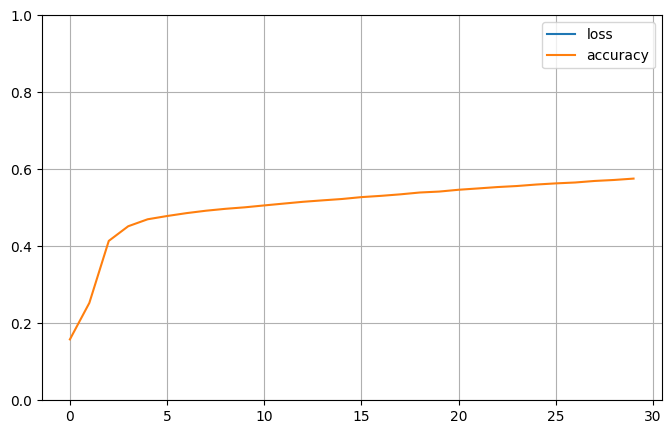

In [44]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [45]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 1.2338 - accuracy: 0.5740
test loss, test acc: [1.2338367700576782, 0.5740125179290771]


In [46]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 12s 5ms/step
[0 0 0 ... 7 7 7]
0
[[5636  492 1427  788    0  584  358  715]
 [1153 5556  836  845    2  138  717  753]
 [2579  599 3720  777    2  624  856  843]
 [ 694  270  640 6483    9  356  824  724]
 [  72   24    1    1 9886    0   13    3]
 [2504  407 1935 1381    1 1471  785 1516]
 [ 414  369  937  826    7  192 6204 1051]
 [ 631  235  499  701    4  326  639 6965]]
              precision    recall  f1-score   support

           0       0.41      0.56      0.48     10000
           1       0.70      0.56      0.62     10000
           2       0.37      0.37      0.37     10000
           3       0.55      0.65      0.59     10000
           4       1.00      0.99      0.99     10000
           5       0.40      0.15      0.21     10000
           6       0.60      0.62      0.61     10000
           7       0.55      0.70      0.62     10000

    accuracy                           0.57     80000
   macro avg       0.57      0.57  

Test Accuracy:0.5740125


Text(0.5, 1.0, 'Accuracy:0.574')

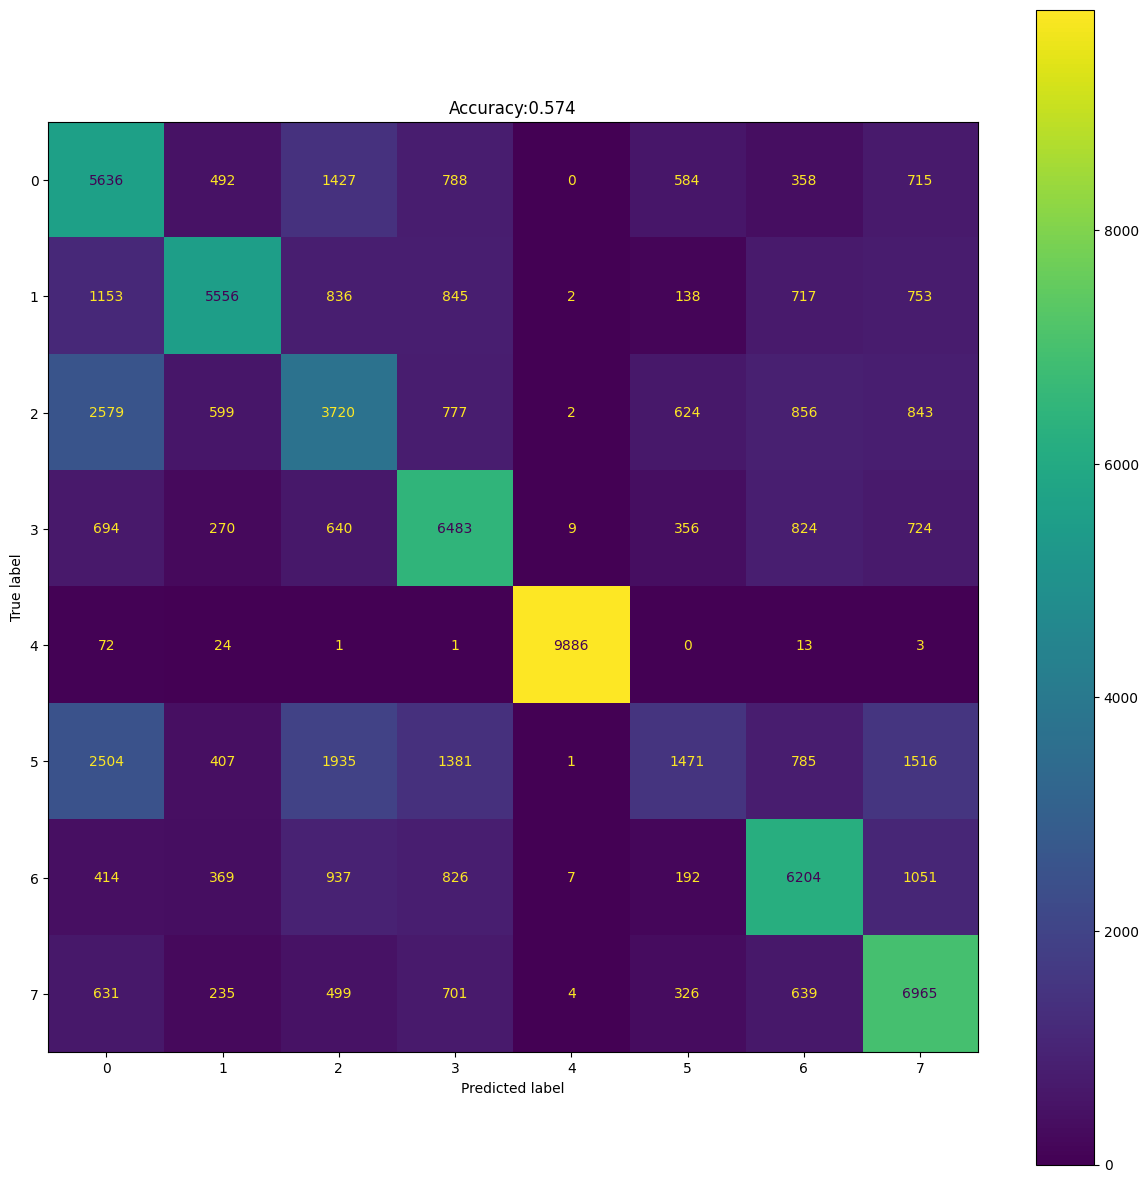

In [47]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-25(v) model to Nordic Device-30(iv) dataset 

In [48]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(v)_model.h5")

In [49]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 13s 5ms/step - loss: 5.2860 - accuracy: 0.1067
test loss, test acc: [5.286040782928467, 0.10671249777078629]


In [50]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 12s 5ms/step
[3 5 5 ... 5 4 3]
3
[[ 206    8 1496  304  572 7335   52   27]
 [  55   80 1731 1008  504 6428   45  149]
 [ 141   15 1504  333  524 7389   38   56]
 [2458    1  671   64 3662 3115   23    6]
 [  17 7225    6   45   90   11  119 2487]
 [ 370   19 1882  202 1053 6380   58   36]
 [ 722   15 1972   72 1686 5307  194   32]
 [1676    8 1958   69  731 5123  416   19]]
              precision    recall  f1-score   support

           0       0.04      0.02      0.03     10000
           1       0.01      0.01      0.01     10000
           2       0.13      0.15      0.14     10000
           3       0.03      0.01      0.01     10000
           4       0.01      0.01      0.01     10000
           5       0.16      0.64      0.25     10000
           6       0.21      0.02      0.04     10000
           7       0.01      0.00      0.00     10000

    accuracy                           0.11     80000
   macro avg       0.07      0.11  

Test Accuracy:0.1067125


Text(0.5, 1.0, 'Accuracy:0.107')

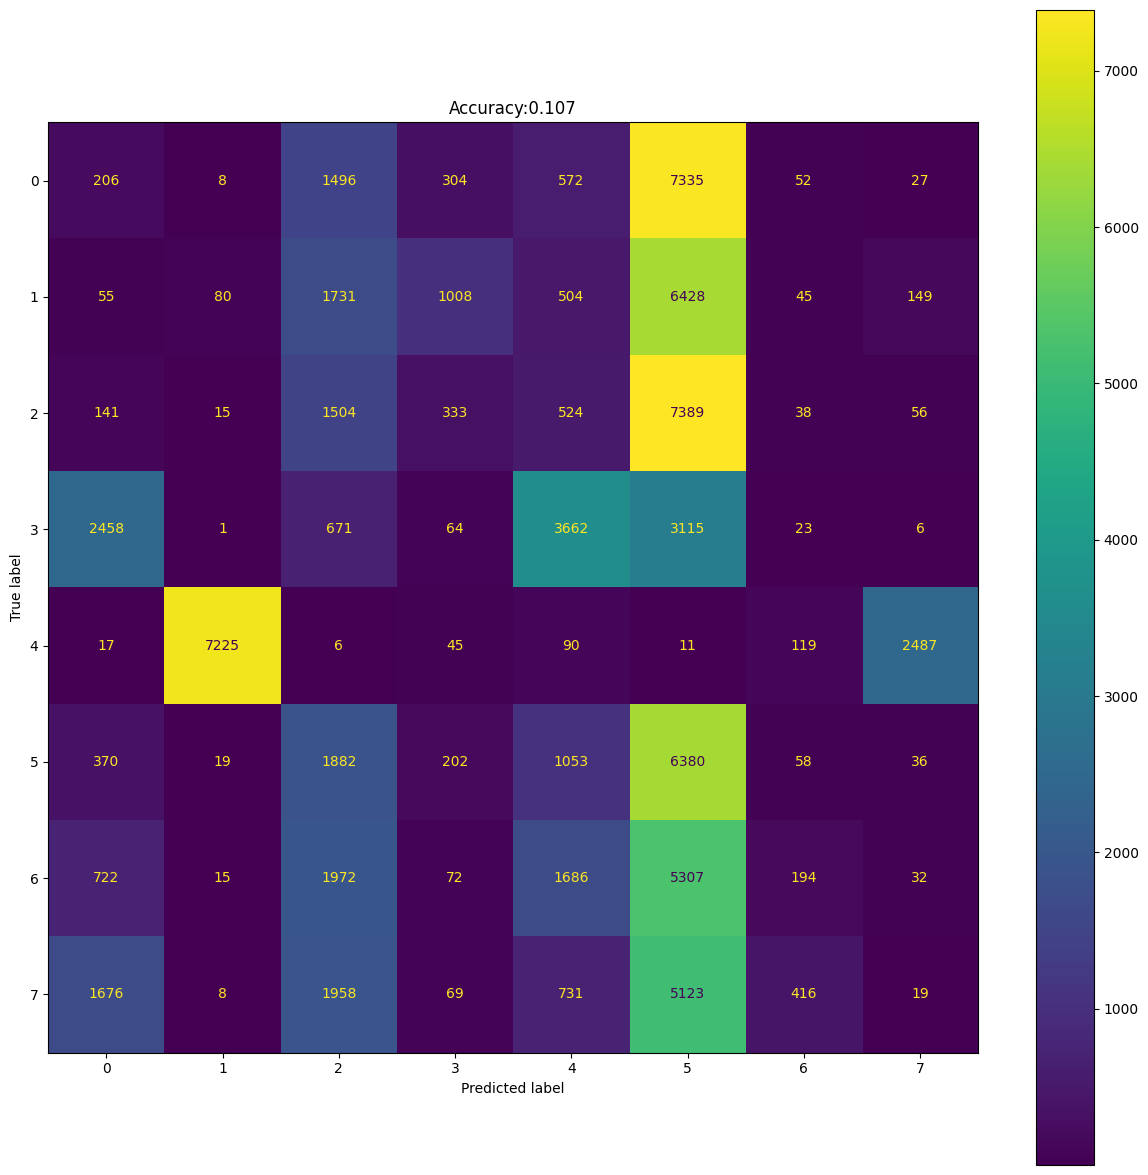

In [51]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning

Nordic Device-25(v) model to Nordic Device-30(iv) dataset 

In [52]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(v)_model.h5")
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1400)              2868600   
                                                                 
 dense_13 (Dense)            (None, 800)               1120800   
                                                                 
 dense_14 (Dense)            (None, 500)               400500    
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [53]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1400)              2868600   
                                                                 
 dense_13 (Dense)            (None, 800)               1120800   
                                                                 
 dense_14 (Dense)            (None, 500)               400500    
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [54]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 12s 5ms/step - loss: 2.8496 - accuracy: 0.1599
Epoch 2/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.8600 - accuracy: 0.3114
Epoch 3/30
2500/2500 [==============================] - 12s 5ms/step - loss: 1.6654 - accuracy: 0.4107
Epoch 4/30
2500/2500 [==============================] - 14s 6ms/step - loss: 1.5751 - accuracy: 0.4403
Epoch 5/30
2500/2500 [==============================] - 16s 7ms/step - loss: 1.5176 - accuracy: 0.4579
Epoch 6/30
2500/2500 [==============================] - 14s 6ms/step - loss: 1.4752 - accuracy: 0.4710
Epoch 7/30
2500/2500 [==============================] - 15s 6ms/step - loss: 1.4421 - accuracy: 0.4798
Epoch 8/30
2500/2500 [==============================] - 15s 6ms/step - loss: 1.4144 - accuracy: 0.4896
Epoch 9/30
2500/2500 [==============================] - 12s 5ms/step - loss: 1.3911 - accuracy: 0.4983
Epoch 10/30
2500/2500 [==============================] - 11s 4ms/step - l

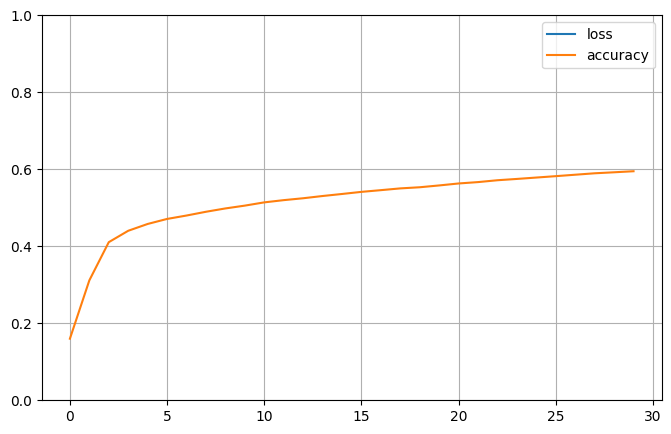

In [55]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [56]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 1.1750 - accuracy: 0.6008
test loss, test acc: [1.1750328540802002, 0.6007624864578247]


In [57]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 12s 5ms/step
[2 0 2 ... 3 7 1]
2
[[3007 1039 2016  707    5 1661  464 1101]
 [ 397 7155  653  177   14  464  670  470]
 [1379 1392 3805  557    7 1278  814  768]
 [ 330   99  320 7585    1  637  482  546]
 [   0   74    0    1 9907    0   18    0]
 [1267  857 1296 1289   11 3387  743 1150]
 [ 196  619  842 1019   22  226 6532  544]
 [ 363  345  436  826   33  776  538 6683]]
              precision    recall  f1-score   support

           0       0.43      0.30      0.36     10000
           1       0.62      0.72      0.66     10000
           2       0.41      0.38      0.39     10000
           3       0.62      0.76      0.68     10000
           4       0.99      0.99      0.99     10000
           5       0.40      0.34      0.37     10000
           6       0.64      0.65      0.64     10000
           7       0.59      0.67      0.63     10000

    accuracy                           0.60     80000
   macro avg       0.59      0.60  

Test Accuracy:0.6007625


Text(0.5, 1.0, 'Accuracy:0.601')

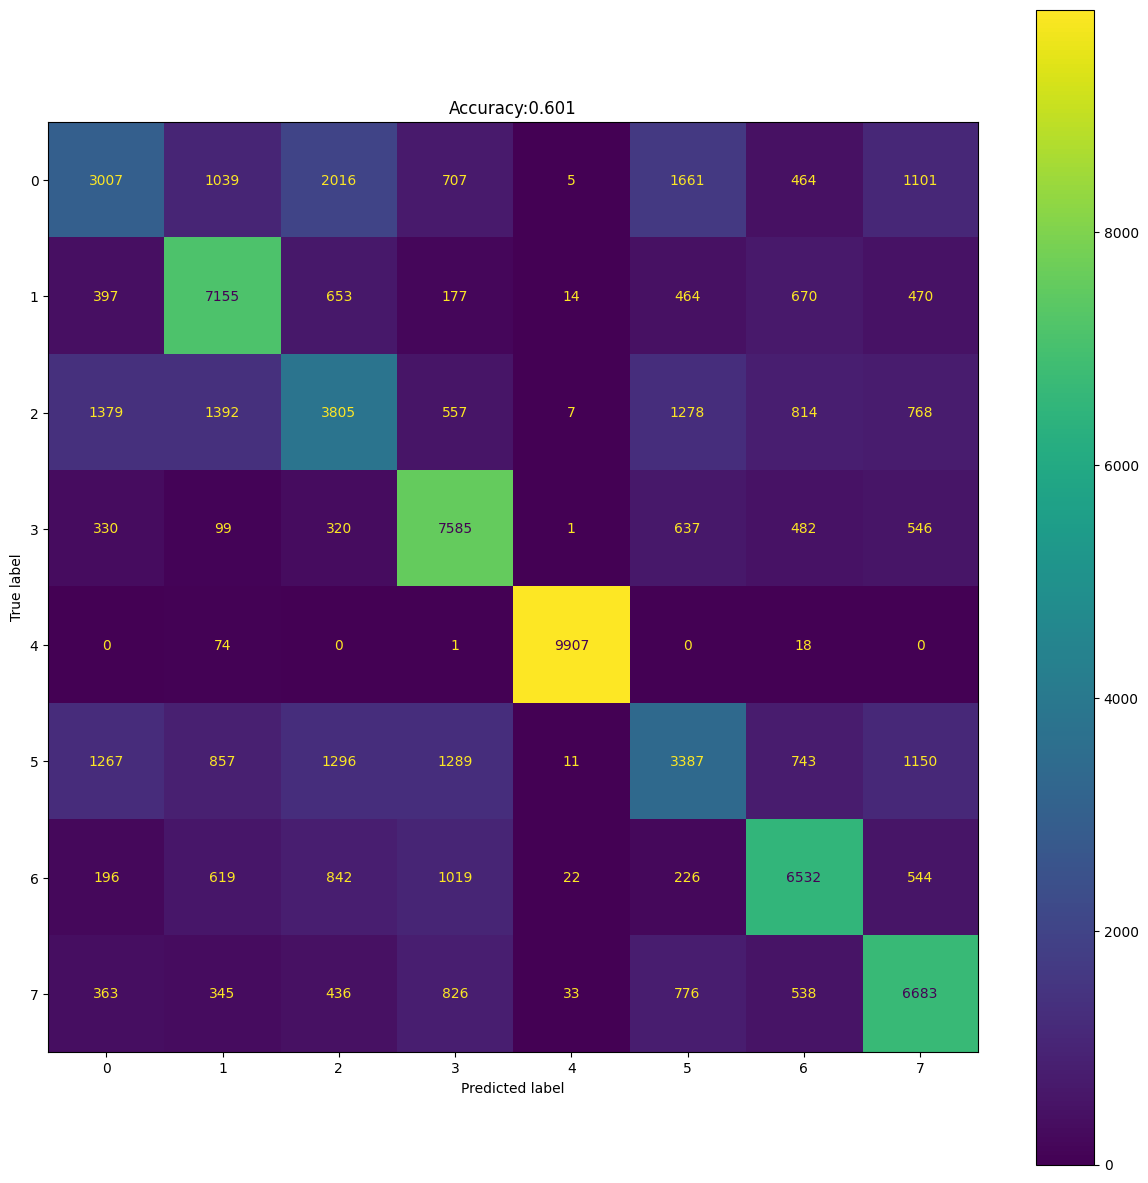

In [58]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Smae Device Other set of Models

Nordic Device-30(i) model to Nordic Device-30(iv) dataset 

In [59]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(i)_model.h5")

In [60]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 14s 5ms/step - loss: 5.9183 - accuracy: 0.1323
test loss, test acc: [5.918274402618408, 0.13228750228881836]


In [61]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 13s 5ms/step
[2 2 2 ... 6 6 2]
2
[[   0    0 8488    7    0  707  798    0]
 [   0    0 9402    1    0   17  510   70]
 [   0    0 7301    3    0  760 1936    0]
 [   0    0 6998    2    0  553 2447    0]
 [  42 9656    7   54   75    1   68   97]
 [   0    0 7683    1    0  652 1664    0]
 [   0    2 6736   71    0  600 2553   38]
 [   0    0 6014    0    0  522 3464    0]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10000
           1       0.00      0.00      0.00     10000
           2       0.14      0.73      0.23     10000
           3       0.01      0.00      0.00     10000
           4       1.00      0.01      0.01     10000
           5       0.17      0.07      0.09     10000
           6       0.19      0.26      0.22     10000
           7       0.00      0.00      0.00     10000

    accuracy                           0.13     80000
   macro avg       0.19      0.13  

Test Accuracy:0.1322875


Text(0.5, 1.0, 'Accuracy:0.132')

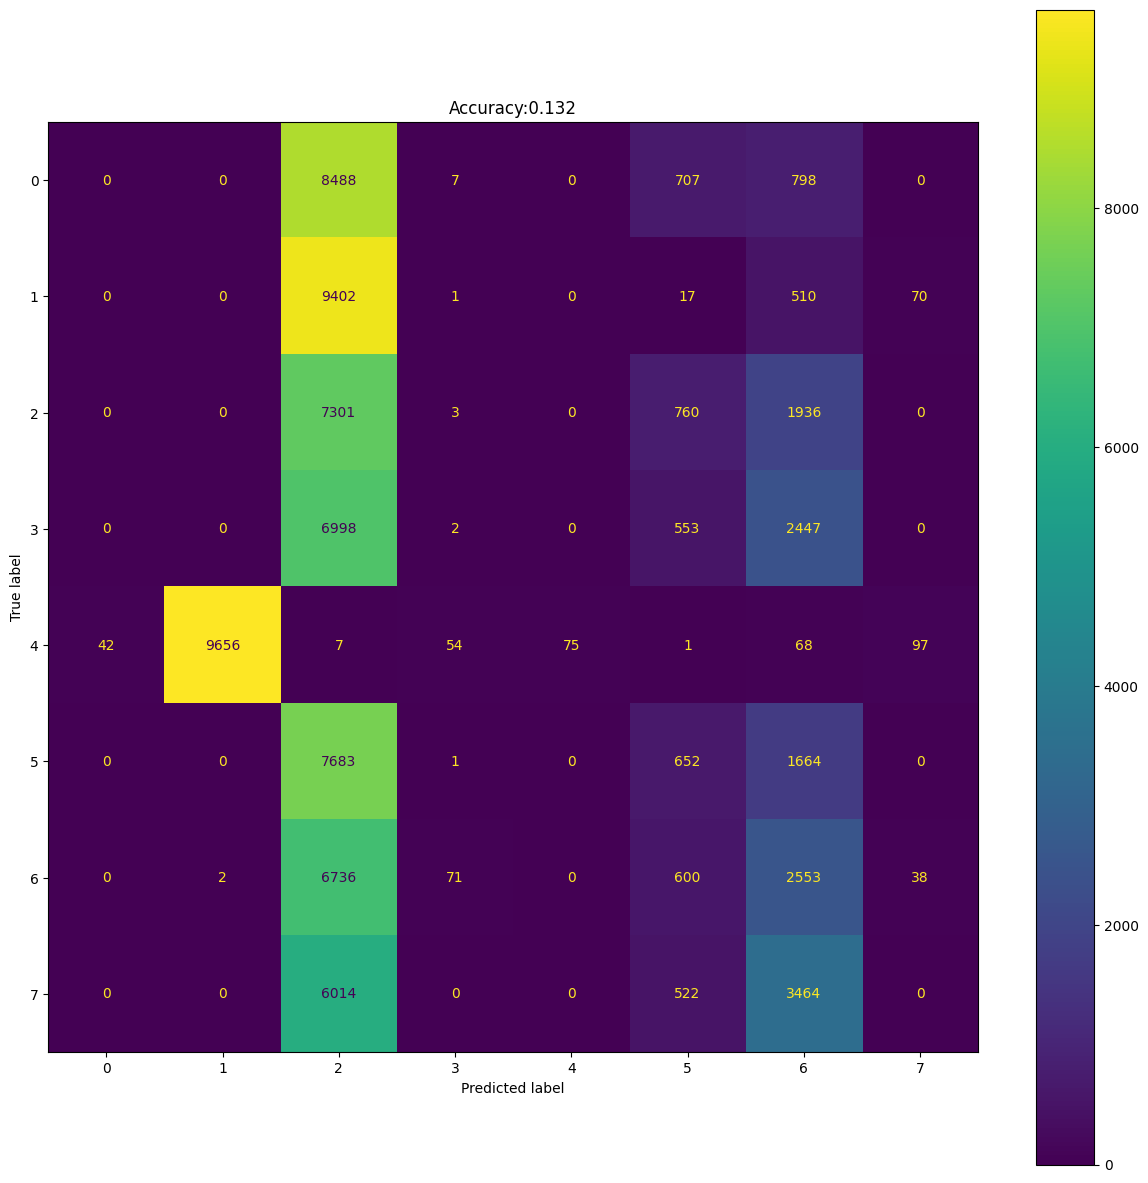

In [62]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation applying the Model of other set of samples

In [63]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(i)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [64]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [65]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 13s 5ms/step - loss: 2.4786 - accuracy: 0.1814
Epoch 2/30
2500/2500 [==============================] - 12s 5ms/step - loss: 1.8189 - accuracy: 0.2649
Epoch 3/30
2500/2500 [==============================] - 13s 5ms/step - loss: 1.6043 - accuracy: 0.4166
Epoch 4/30
2500/2500 [==============================] - 14s 5ms/step - loss: 1.4999 - accuracy: 0.4521
Epoch 5/30
2500/2500 [==============================] - 14s 5ms/step - loss: 1.4407 - accuracy: 0.4709
Epoch 6/30
2500/2500 [==============================] - 14s 5ms/step - loss: 1.4013 - accuracy: 0.4838
Epoch 7/30
2500/2500 [==============================] - 13s 5ms/step - loss: 1.3721 - accuracy: 0.4957
Epoch 8/30
2500/2500 [==============================] - 14s 5ms/step - loss: 1.3495 - accuracy: 0.5058
Epoch 9/30
2500/2500 [==============================] - 12s 5ms/step - loss: 1.3307 - accuracy: 0.5146
Epoch 10/30
2500/2500 [==============================] - 12s 5ms/step - l

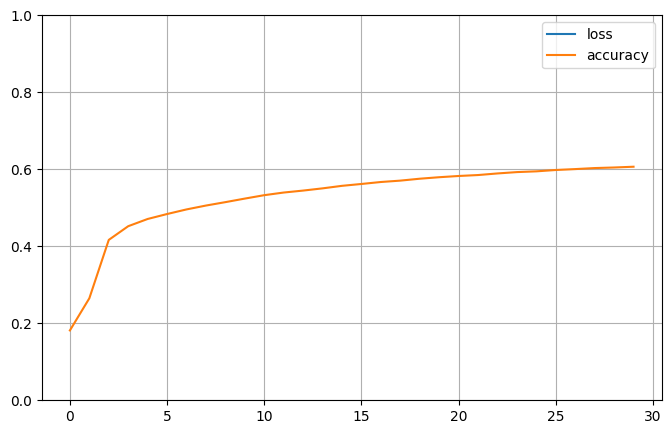

In [66]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [67]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 1.1381 - accuracy: 0.6068
test loss, test acc: [1.138142704963684, 0.6067749857902527]


In [68]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 12s 5ms/step
[0 0 2 ... 7 7 7]
0
[[5194  513 1823  738    0  319  927  486]
 [ 378 8672  313  204    1   29  271  132]
 [2007  418 4520 1092    0  271  890  802]
 [1019  437  878 6214    0  101  873  478]
 [   2    0    0    0 9907    0    6   85]
 [2169  553 2310 1487    0 1070 1335 1076]
 [ 527  356  583  647    3   83 7494  307]
 [ 949  406 1219  813    0  213  929 5471]]
              precision    recall  f1-score   support

           0       0.42      0.52      0.47     10000
           1       0.76      0.87      0.81     10000
           2       0.39      0.45      0.42     10000
           3       0.56      0.62      0.59     10000
           4       1.00      0.99      1.00     10000
           5       0.51      0.11      0.18     10000
           6       0.59      0.75      0.66     10000
           7       0.62      0.55      0.58     10000

    accuracy                           0.61     80000
   macro avg       0.61      0.61  

Test Accuracy:0.606775


Text(0.5, 1.0, 'Accuracy:0.607')

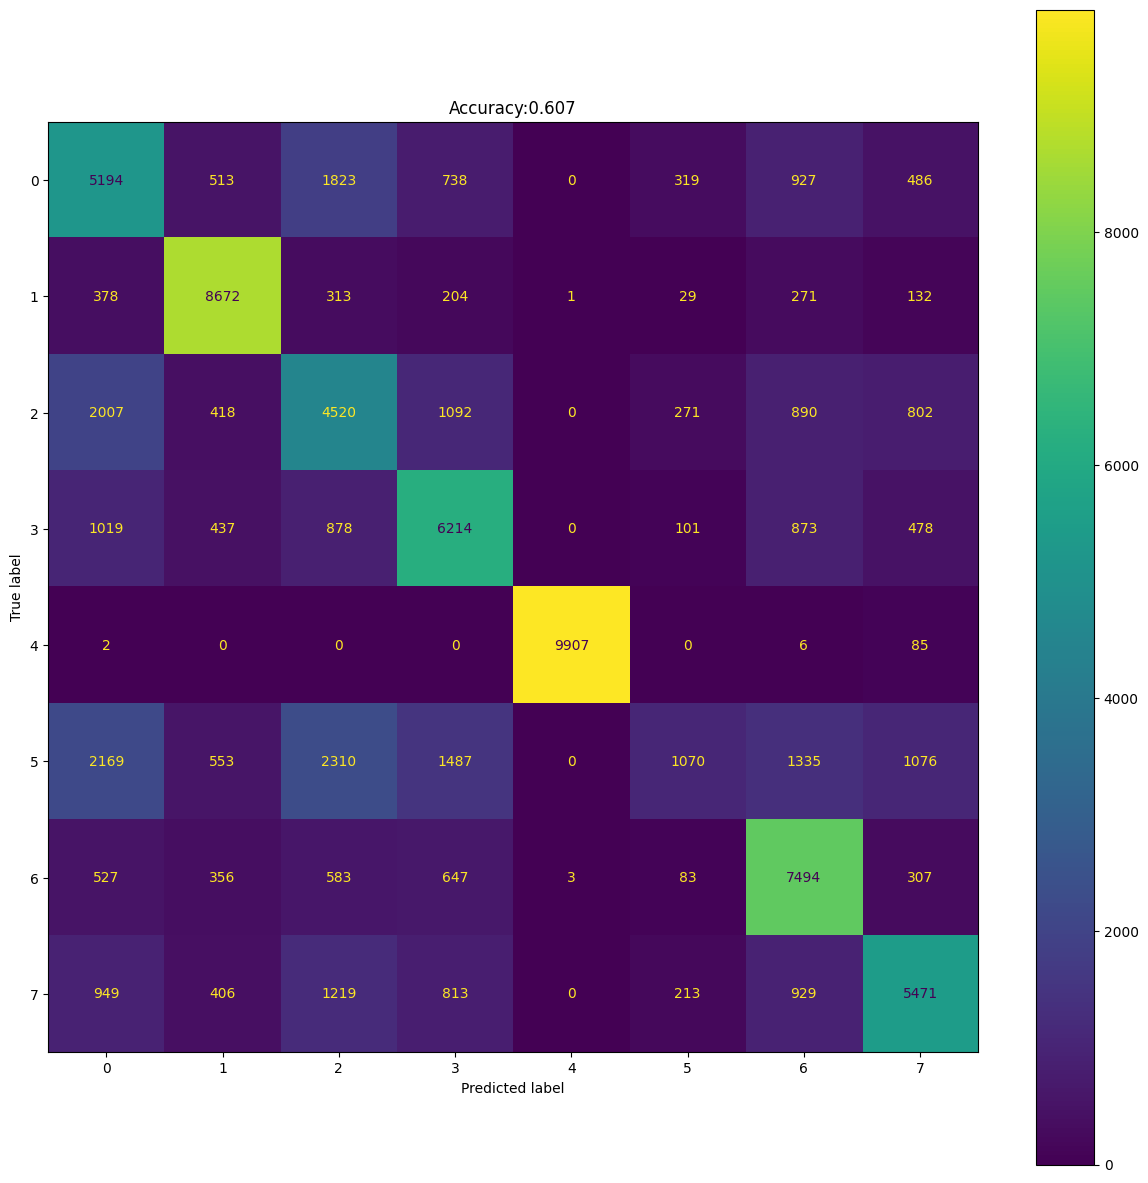

In [69]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-30(ii) model to Nordic Device-30(iv) dataset 

In [70]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(ii)_model.h5")

In [71]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 13s 5ms/step - loss: 5.7113 - accuracy: 0.1712
test loss, test acc: [5.711341857910156, 0.17116250097751617]


In [72]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 12s 5ms/step
[2 5 5 ... 5 5 5]
2
[[  19    0 3348    1    0 6178  453    1]
 [   0  101 2585    8    0 5875 1304  127]
 [  23    3 2841    1    0 6147  983    2]
 [  33    0 2665    0    0 6224 1076    2]
 [  20  143   12   30   82   40  104 9569]
 [  20    0 2294    0    0 7043  642    1]
 [   4   16 1566   50    0 4704 3606   54]
 [  10    1 2543    3    0 5576 1866    1]]
              precision    recall  f1-score   support

           0       0.15      0.00      0.00     10000
           1       0.38      0.01      0.02     10000
           2       0.16      0.28      0.20     10000
           3       0.00      0.00      0.00     10000
           4       1.00      0.01      0.02     10000
           5       0.17      0.70      0.27     10000
           6       0.36      0.36      0.36     10000
           7       0.00      0.00      0.00     10000

    accuracy                           0.17     80000
   macro avg       0.28      0.17  

Test Accuracy:0.1711625


Text(0.5, 1.0, 'Accuracy:0.171')

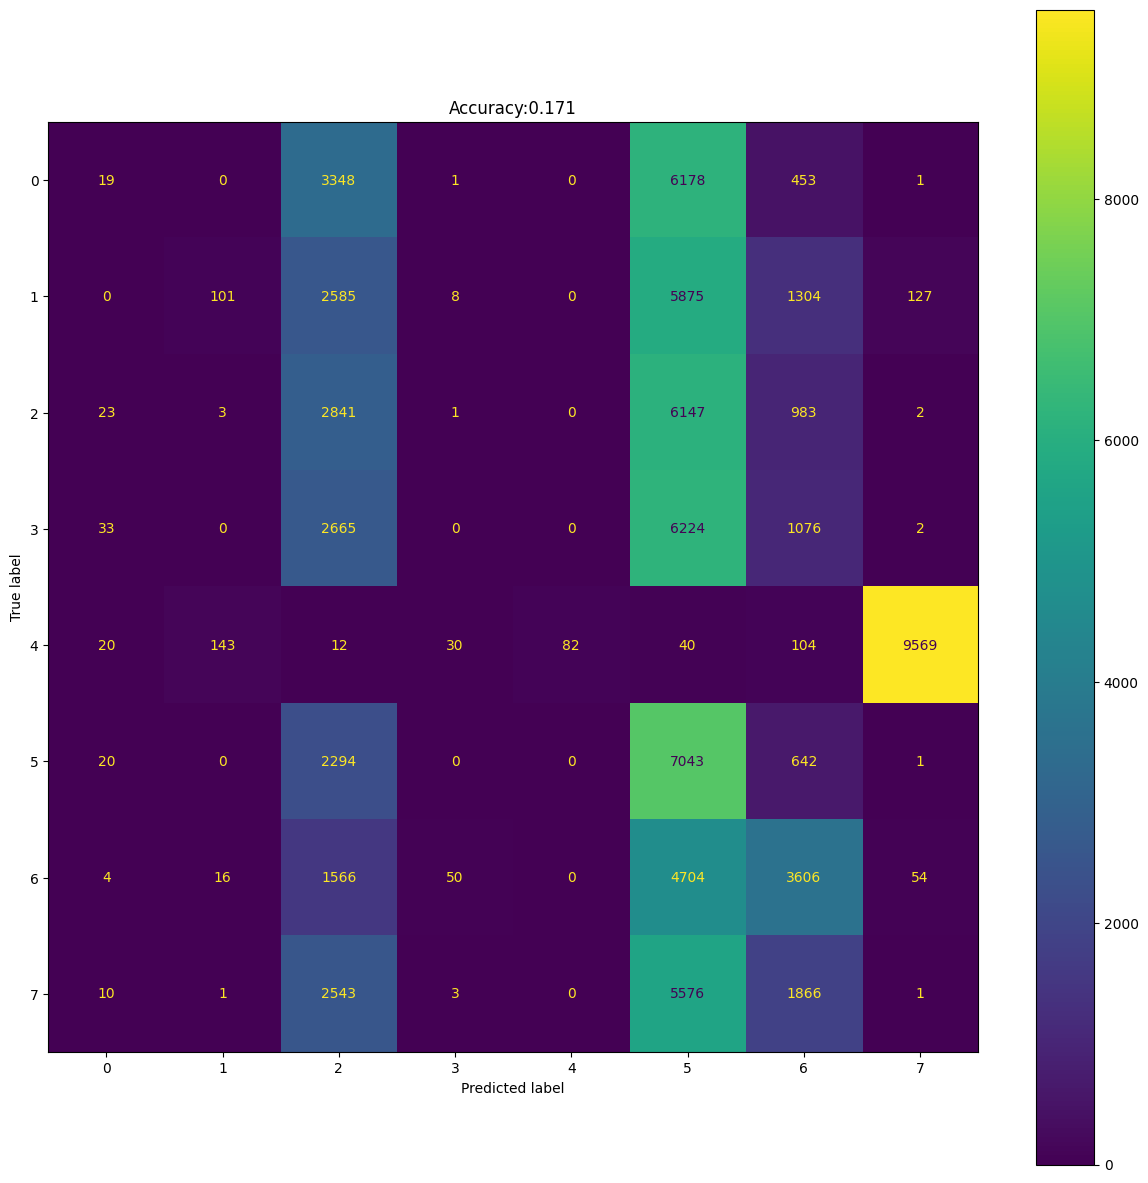

In [73]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [74]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(ii)_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [75]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [76]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 13s 5ms/step - loss: 2.5998 - accuracy: 0.1932
Epoch 2/30
2500/2500 [==============================] - 14s 6ms/step - loss: 1.9322 - accuracy: 0.2432
Epoch 3/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.7007 - accuracy: 0.3814
Epoch 4/30
2500/2500 [==============================] - 13s 5ms/step - loss: 1.5960 - accuracy: 0.4071
Epoch 5/30
2500/2500 [==============================] - 15s 6ms/step - loss: 1.5379 - accuracy: 0.4286
Epoch 6/30
2500/2500 [==============================] - 14s 5ms/step - loss: 1.4991 - accuracy: 0.4428
Epoch 7/30
2500/2500 [==============================] - 14s 6ms/step - loss: 1.4702 - accuracy: 0.4553
Epoch 8/30
2500/2500 [==============================] - 12s 5ms/step - loss: 1.4471 - accuracy: 0.4661
Epoch 9/30
2500/2500 [==============================] - 14s 6ms/step - loss: 1.4272 - accuracy: 0.4762
Epoch 10/30
2500/2500 [==============================] - 12s 5ms/step - l

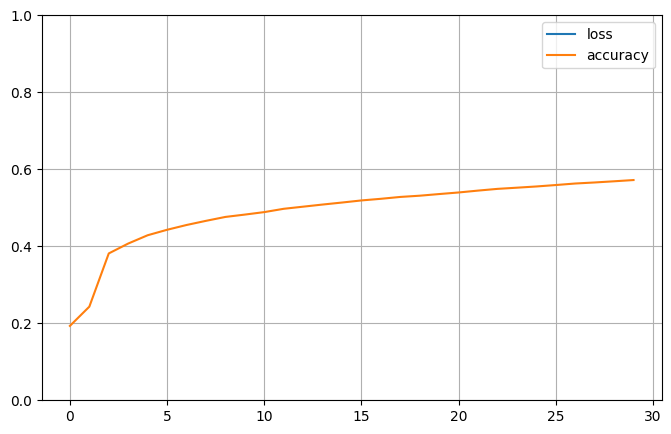

In [77]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [78]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 1.2108 - accuracy: 0.5778
test loss, test acc: [1.2107568979263306, 0.5778375267982483]


In [79]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 12s 5ms/step
[0 5 5 ... 7 7 7]
0
[[4856  548  963 1063    0 1171  612  787]
 [ 326 7328  333  757    1  183  752  320]
 [2658  680 2379 1150    0 1041 1023 1069]
 [ 766  652  353 6706    0  318  494  711]
 [   0    2    0    1 9925    0   31   41]
 [2647  732  850 1449    1 2188  647 1486]
 [ 602  974  502  621    9  224 6209  859]
 [ 618  483  350  827    0  403  683 6636]]
              precision    recall  f1-score   support

           0       0.39      0.49      0.43     10000
           1       0.64      0.73      0.68     10000
           2       0.42      0.24      0.30     10000
           3       0.53      0.67      0.59     10000
           4       1.00      0.99      1.00     10000
           5       0.40      0.22      0.28     10000
           6       0.59      0.62      0.61     10000
           7       0.56      0.66      0.61     10000

    accuracy                           0.58     80000
   macro avg       0.57      0.58  

Test Accuracy:0.5778375


Text(0.5, 1.0, 'Accuracy:0.578')

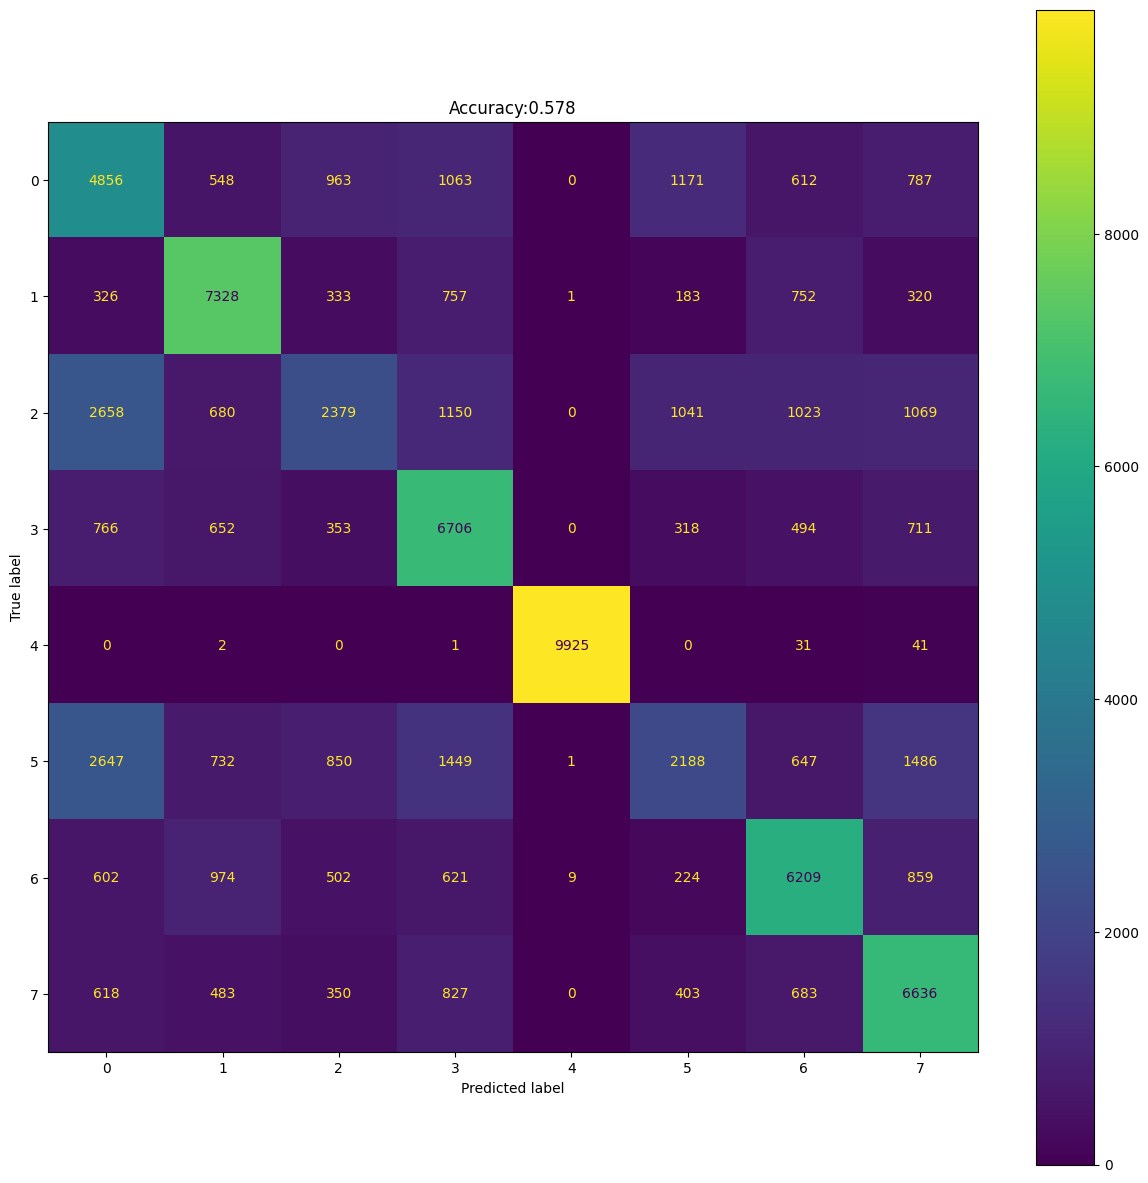

In [80]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-30(iii) model to Nordic Device-30(iv) dataset 

In [81]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(iii)_model.h5")

In [82]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 13s 5ms/step - loss: 1.5378 - accuracy: 0.6041
test loss, test acc: [1.537827491760254, 0.6040874719619751]


In [83]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 13s 5ms/step
[4 5 5 ... 7 7 7]
4
[[  52   15 1462  300 3718 4159   90  204]
 [   3 9961   21    0    8    6    1    0]
 [   4   23 3716  239  484 4546  941   47]
 [   0    0   44 9928    0   17   10    1]
 [9718   42    3   31   81   13   86   26]
 [  25   13 3373  232  924 5043  183  207]
 [   0    0  244    6   14   35 9698    3]
 [   1    0   79    5   15   47    5 9848]]
              precision    recall  f1-score   support

           0       0.01      0.01      0.01     10000
           1       0.99      1.00      0.99     10000
           2       0.42      0.37      0.39     10000
           3       0.92      0.99      0.96     10000
           4       0.02      0.01      0.01     10000
           5       0.36      0.50      0.42     10000
           6       0.88      0.97      0.92     10000
           7       0.95      0.98      0.97     10000

    accuracy                           0.60     80000
   macro avg       0.57      0.60  

Test Accuracy:0.6040875


Text(0.5, 1.0, 'Accuracy:0.604')

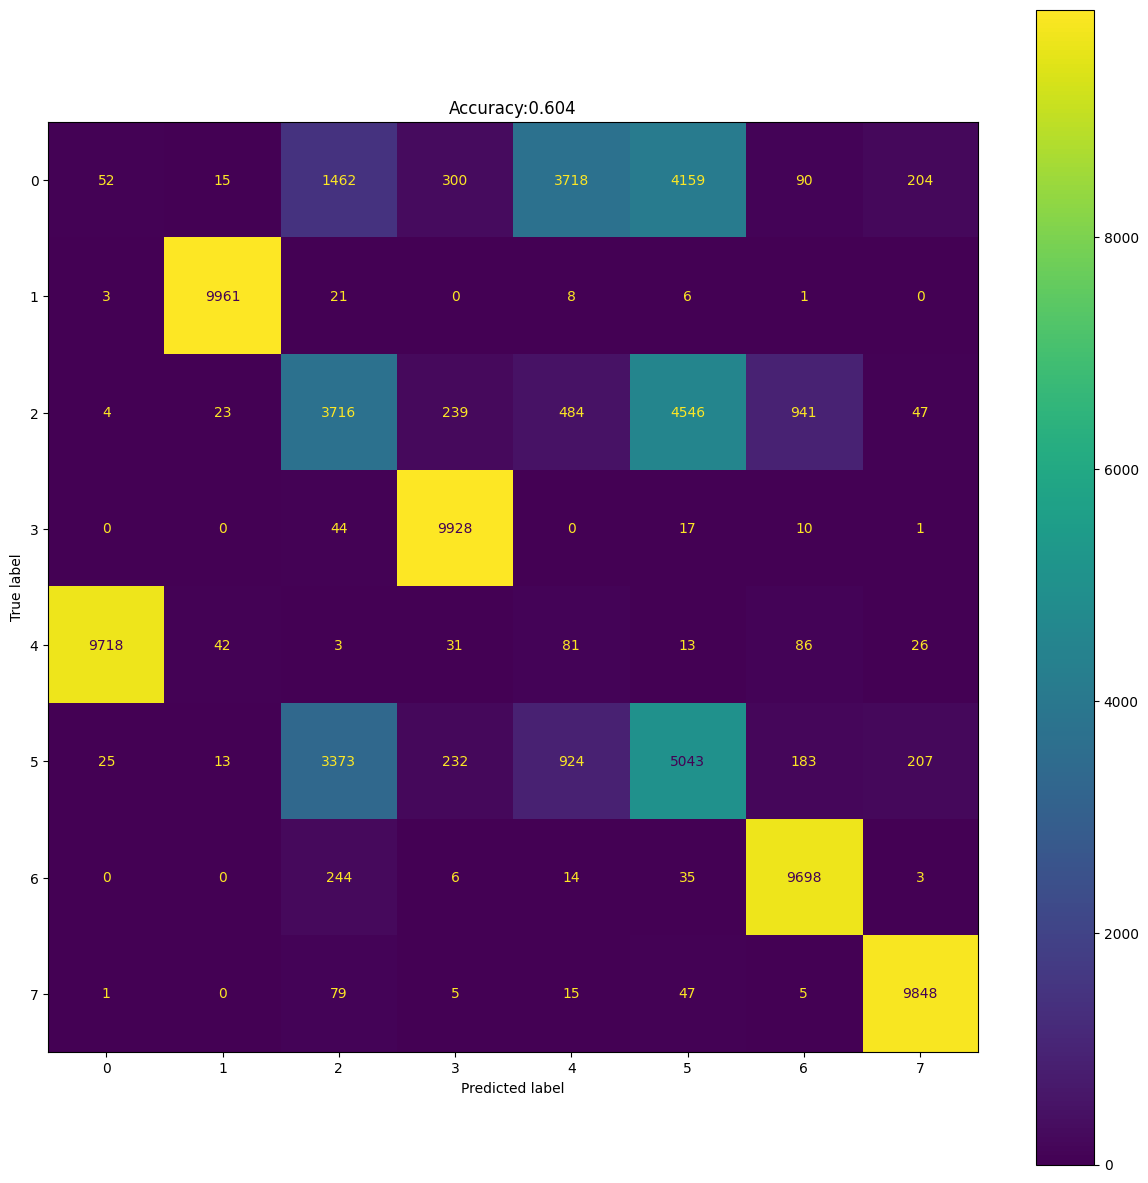

In [84]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [85]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(iii)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [86]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [87]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 0.9015 - accuracy: 0.6559
Epoch 2/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.6867 - accuracy: 0.7855
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.5760 - accuracy: 0.8097
Epoch 4/30
2500/2500 [==============================] - 11s 4ms/step - loss: 0.5179 - accuracy: 0.8225
Epoch 5/30
2500/2500 [==============================] - 11s 4ms/step - loss: 0.4846 - accuracy: 0.8299
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.4630 - accuracy: 0.8349
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.4475 - accuracy: 0.8366
Epoch 8/30
2500/2500 [==============================] - 11s 4ms/step - loss: 0.4359 - accuracy: 0.8392
Epoch 9/30
2500/2500 [==============================] - 11s 4ms/step - loss: 0.4268 - accuracy: 0.8396
Epoch 10/30
2500/2500 [==============================] - 12s 5ms/step - l

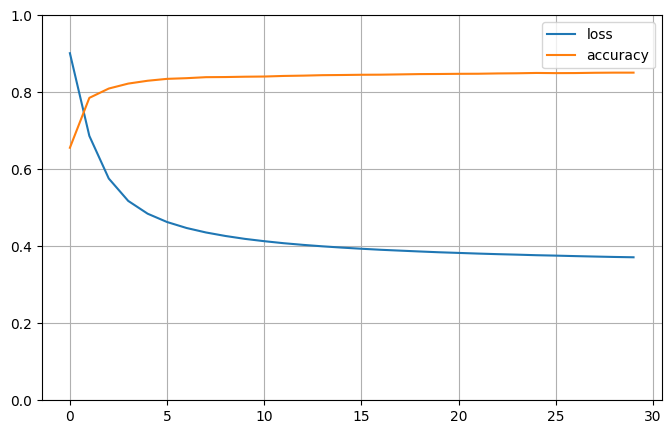

In [88]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [89]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 0.3704 - accuracy: 0.8522
test loss, test acc: [0.3704042136669159, 0.852150022983551]


In [90]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 12s 5ms/step
[0 0 0 ... 7 7 7]
0
[[6916    0  918   28   23 2084    6   25]
 [   4 9949   14    0    7   26    0    0]
 [ 937    1 6826   37    1 1998  191    9]
 [   6    0   52 9913    1   23    5    0]
 [   9    0   25    4 9926    4   25    7]
 [2401    1 2524   22    6 5005   12   29]
 [  27    0  168    2    0   13 9790    0]
 [  52    0   33    1    0   65    2 9847]]
              precision    recall  f1-score   support

           0       0.67      0.69      0.68     10000
           1       1.00      0.99      1.00     10000
           2       0.65      0.68      0.66     10000
           3       0.99      0.99      0.99     10000
           4       1.00      0.99      0.99     10000
           5       0.54      0.50      0.52     10000
           6       0.98      0.98      0.98     10000
           7       0.99      0.98      0.99     10000

    accuracy                           0.85     80000
   macro avg       0.85      0.85  

Test Accuracy:0.85215


Text(0.5, 1.0, 'Accuracy:0.852')

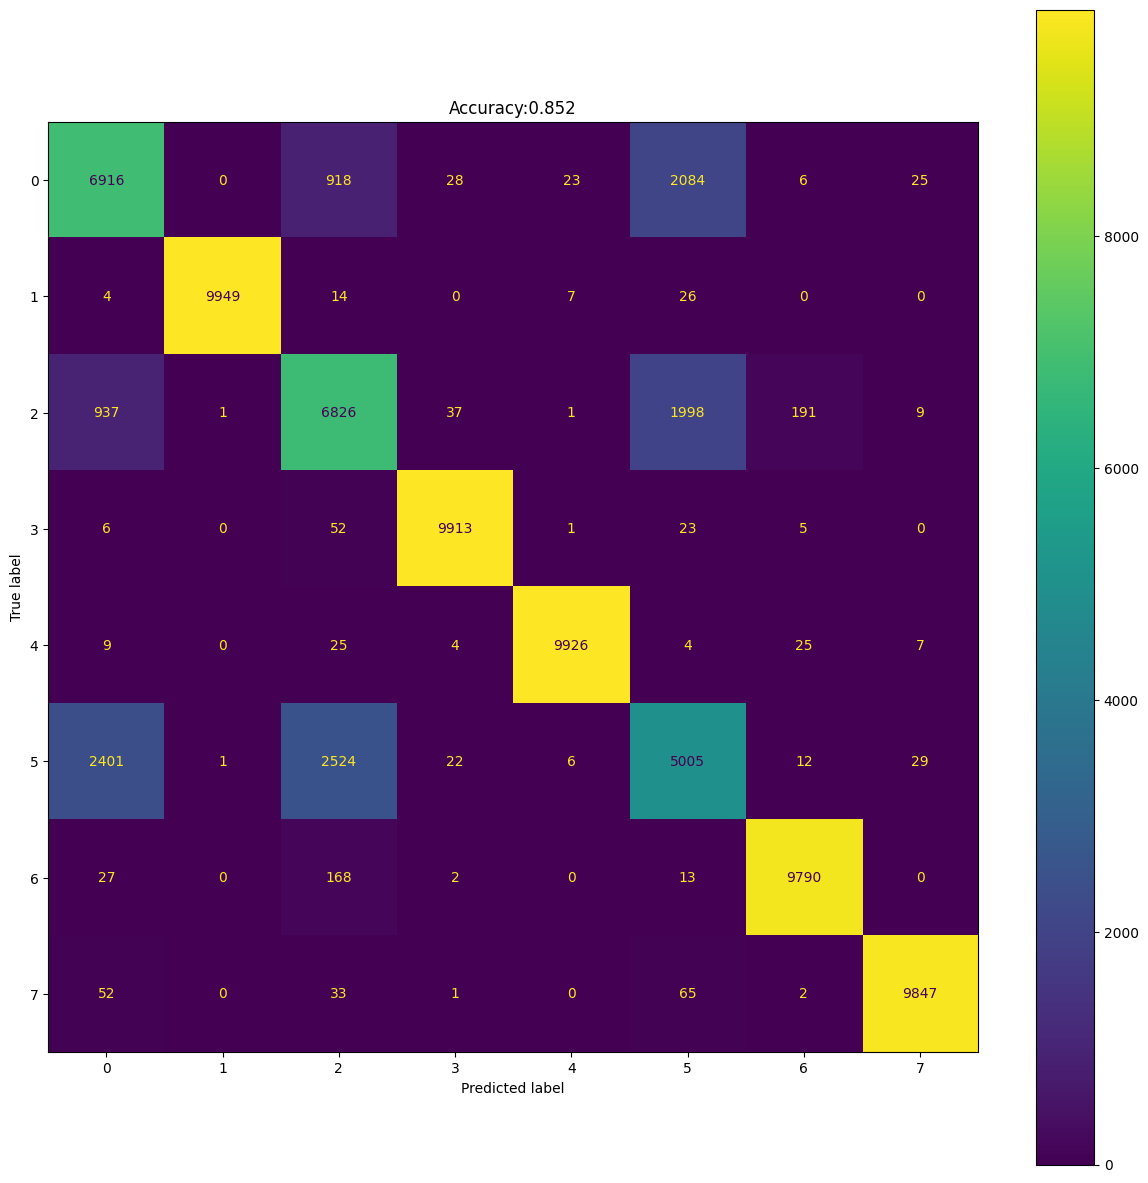

In [91]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-30(v) model to Nordic Device-30(iv) dataset 

In [95]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(v)_model.h5")

In [96]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 0.4153 - accuracy: 0.8592
test loss, test acc: [0.41526997089385986, 0.8592374920845032]


In [94]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 11s 4ms/step
[0 5 0 ... 7 7 5]
0
[[7445    1  140   34    0 2374    4    2]
 [  15 9952   10    2    0   19    2    0]
 [1792   18 6336  274    0 1491   88    1]
 [   2    0    6 9982    0    9    1    0]
 [  36    1    1    6 9926   12    0   18]
 [3379    3  271   87    0 6249    9    2]
 [  65    1  830   20    1   67 9016    0]
 [  47    0    3    0    0  117    0 9833]]
              precision    recall  f1-score   support

           0       0.58      0.74      0.65     10000
           1       1.00      1.00      1.00     10000
           2       0.83      0.63      0.72     10000
           3       0.96      1.00      0.98     10000
           4       1.00      0.99      1.00     10000
           5       0.60      0.62      0.61     10000
           6       0.99      0.90      0.94     10000
           7       1.00      0.98      0.99     10000

    accuracy                           0.86     80000
   macro avg       0.87      0.86  

Test Accuracy:0.8592375


Text(0.5, 1.0, 'Accuracy:0.859')

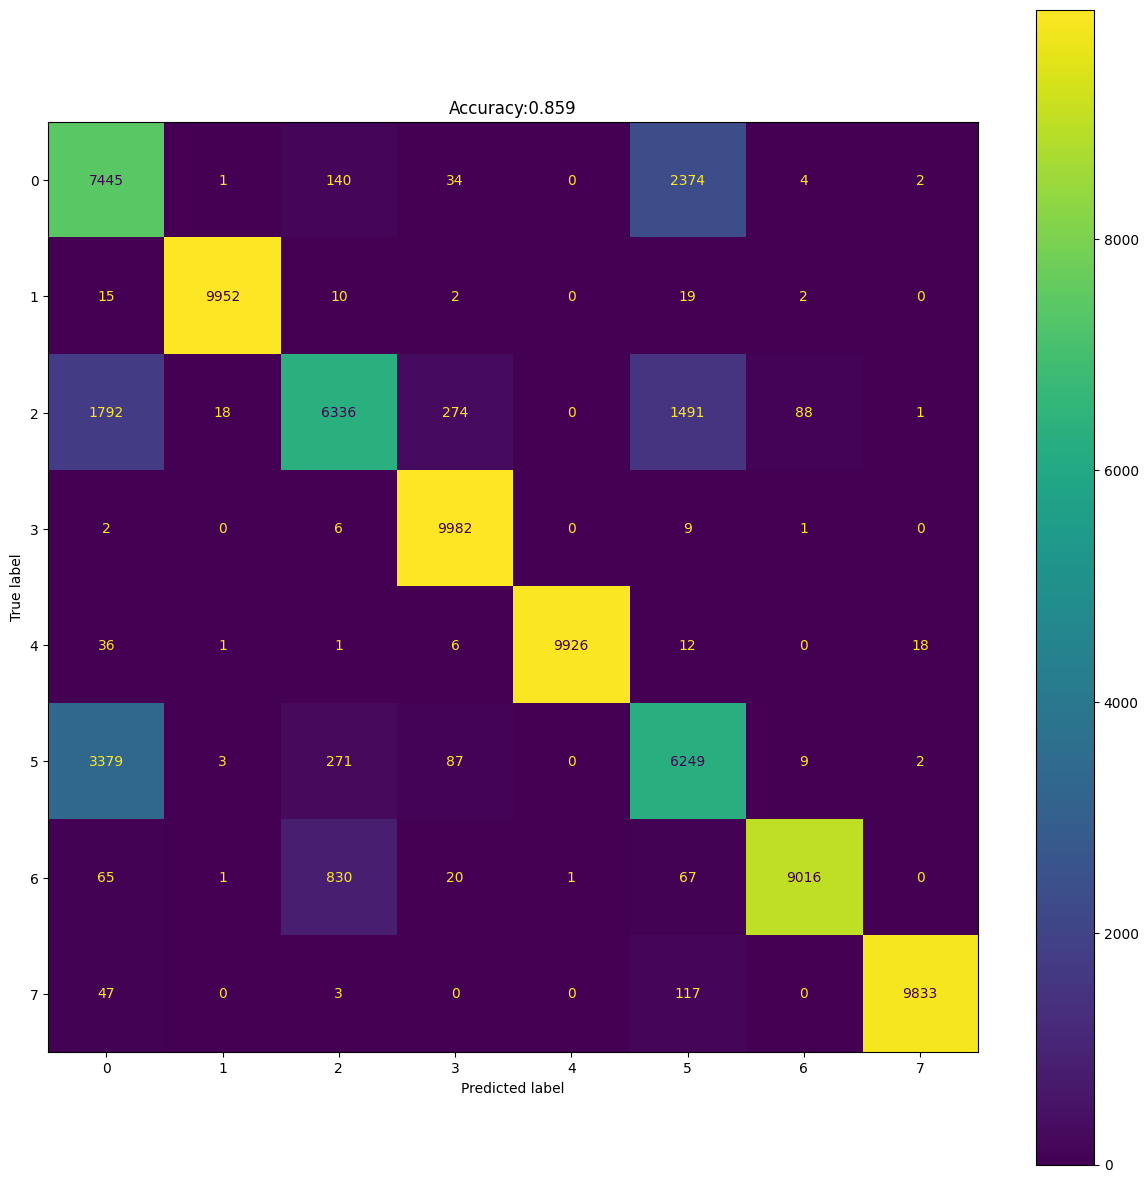

In [97]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')



## Cross-model Validation by applying Transfer Learning of other Device's Model

In [98]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(v)_model.h5")
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1400)              2868600   
                                                                 
 dense_13 (Dense)            (None, 800)               1120800   
                                                                 
 dense_14 (Dense)            (None, 500)               400500    
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [99]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1400)              2868600   
                                                                 
 dense_13 (Dense)            (None, 800)               1120800   
                                                                 
 dense_14 (Dense)            (None, 500)               400500    
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [100]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 13s 5ms/step - loss: 0.3401 - accuracy: 0.8815
Epoch 2/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.3067 - accuracy: 0.8869
Epoch 3/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.2871 - accuracy: 0.8902
Epoch 4/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.2745 - accuracy: 0.8930
Epoch 5/30
2500/2500 [==============================] - 11s 4ms/step - loss: 0.2664 - accuracy: 0.8948
Epoch 6/30
2500/2500 [==============================] - 11s 4ms/step - loss: 0.2609 - accuracy: 0.8957
Epoch 7/30
2500/2500 [==============================] - 11s 4ms/step - loss: 0.2573 - accuracy: 0.8975
Epoch 8/30
2500/2500 [==============================] - 13s 5ms/step - loss: 0.2547 - accuracy: 0.8987
Epoch 9/30
2500/2500 [==============================] - 13s 5ms/step - loss: 0.2525 - accuracy: 0.8991
Epoch 10/30
2500/2500 [==============================] - 14s 6ms/step - l

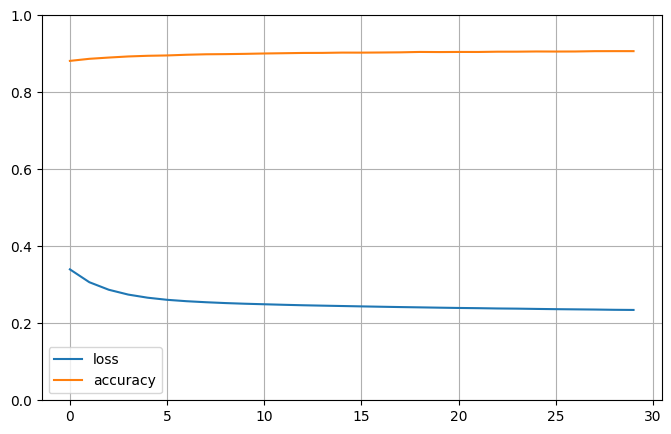

In [101]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [102]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 0.2338 - accuracy: 0.9074
test loss, test acc: [0.233756884932518, 0.9073625206947327]


In [103]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 12s 5ms/step
[0 5 0 ... 7 7 7]
0
[[7174    0  543    0    0 2260   14    9]
 [   3 9947   23    0    0   25    2    0]
 [ 353    1 8768   11    0  683  183    1]
 [   1    0   34 9951    0   10    4    0]
 [  40    0    1    0 9931    8    1   19]
 [2111    1  836    6    0 7013   24    9]
 [   7    0  113    0    0   35 9845    0]
 [  10    0    4    0    0   26    0 9960]]
              precision    recall  f1-score   support

           0       0.74      0.72      0.73     10000
           1       1.00      0.99      1.00     10000
           2       0.85      0.88      0.86     10000
           3       1.00      1.00      1.00     10000
           4       1.00      0.99      1.00     10000
           5       0.70      0.70      0.70     10000
           6       0.98      0.98      0.98     10000
           7       1.00      1.00      1.00     10000

    accuracy                           0.91     80000
   macro avg       0.91      0.91  

Test Accuracy:0.9073625


Text(0.5, 1.0, 'Accuracy:0.907')

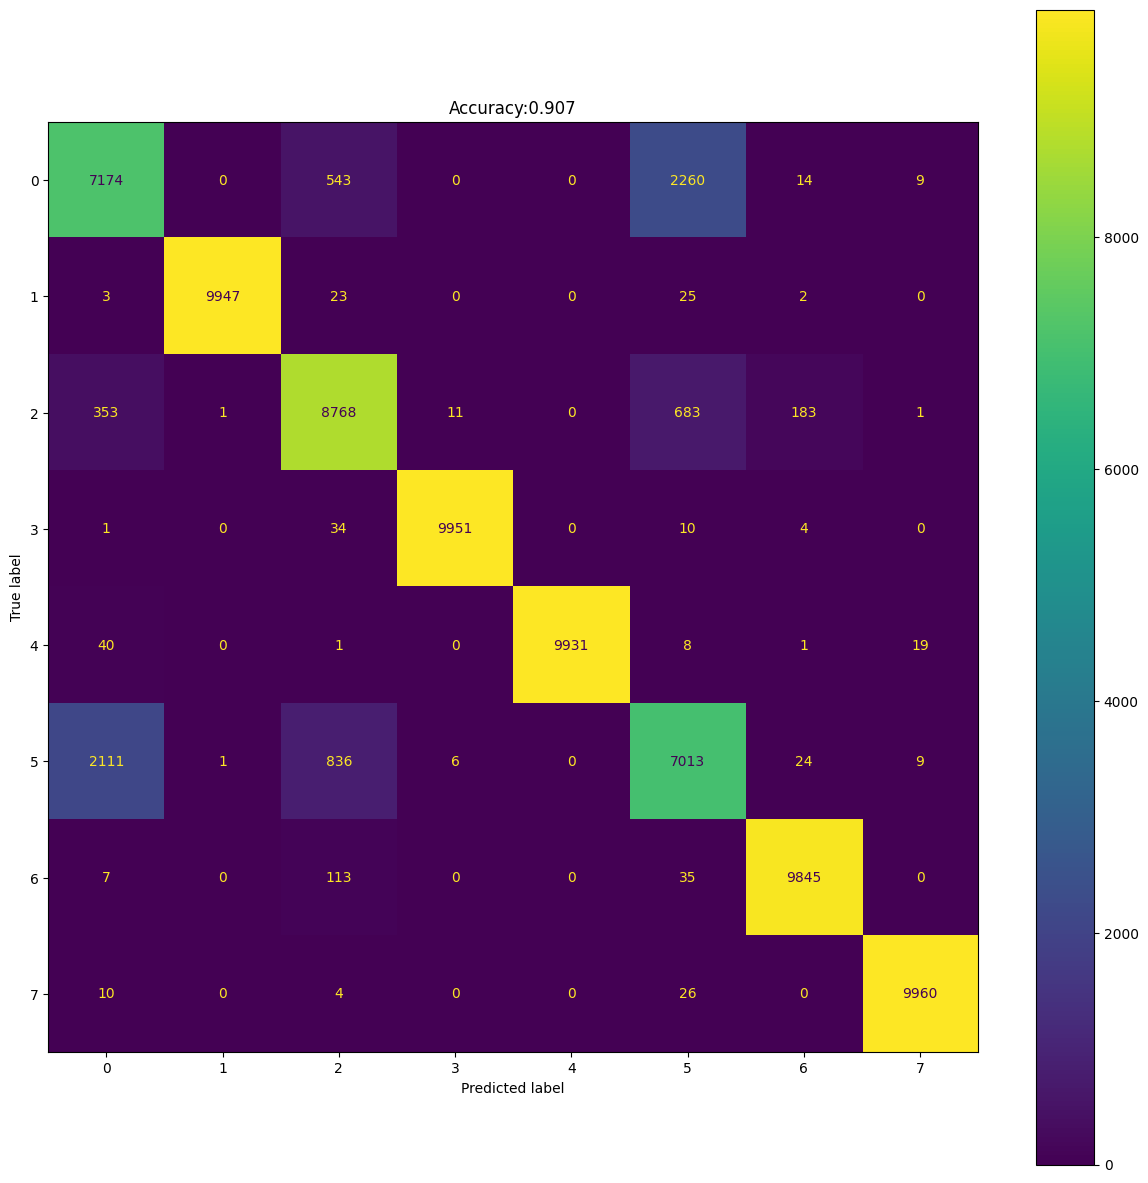

In [104]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')